# このNotebookについて

このNotebookでは、PlanckThermometerで行われる温度計算処理の開発(と簡単なテスト)を行います。

# 事前処理

In [174]:
# 外部ライブラリのimport
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.constants import h, c, k  # プランク定数, 光速, ボルツマン定数
from scipy.optimize import curve_fit

In [2]:
# 自作ライブラリのimport

# ファイル読み込み
from modules.file_format.spe_wrapper import SpeWrapper
from modules.file_format.lightfield_csv_wrapper import LightfieldCsv
# データ処理
from modules.data_model.raw_spectrum_data import RawSpectrumData
# Fittingクラス
# 図を作る処理を書いたクラス
# しきい値を決定するときに使うクラス


# テストデータの読み込み

## 参照スペクトルデータ

In [3]:
# 参照スペクトルデータ

path_to_ref_spectrum = "/Users/ishizawaosamu/work/MasterThesis/test-data/planck-thermo-calculator/OIbDia08_2nd/2024_0403/OL245C.csv"

ref_spectrum = pd.read_csv(
    path_to_ref_spectrum,
    header=None,
    names=["wavelength", "intensity"]
)

## データセット1

In [4]:
# 元の露光データ
path_to_raw_radiation_1 = '/Users/ishizawaosamu/work/MasterThesis/test-data/planck-thermo-calculator/OIbDia08_2nd/rotated_OIbDia08_4.spe'

# 上流・下流のフィルター補正値
path_to_up_filter_1 = '/Users/ishizawaosamu/work/MasterThesis/test-data/planck-thermo-calculator/OIbDia08_2nd/2024_0403/Standard/6_Up_std.spe'
path_to_down_filter_1 = '/Users/ishizawaosamu/work/MasterThesis/test-data/planck-thermo-calculator/OIbDia08_2nd/2024_0403/Standard/6-Down_std.spe'

# 較正後スペクトルデータ
path_to_calibrated_1 = '/Users/ishizawaosamu/work/MasterThesis/test-data/planck-thermo-calculator/OIbDia08_2nd/rotated_OIbDia08_4_calib.csv'

# 温度分布データ
path_to_dist_1 = '/Users/ishizawaosamu/work/MasterThesis/test-data/planck-thermo-calculator/OIbDia08_2nd/rotated_OIbDia08_4_dist(30).csv'

In [5]:
# インスタンス化

# 露光データ
raw_spe_1 = SpeWrapper(path_to_raw_radiation_1)
raw_radiation_1 = RawSpectrumData(raw_spe_1)
# フィルター
up_1 = SpeWrapper(path_to_up_filter_1)
down_1 = SpeWrapper(path_to_down_filter_1)
# 校正後のスペクトルデータ
ans_calib_1 = LightfieldCsv(path_to_calibrated_1, 'calib')
ans_calib_1.set_calib_pixel(
    position_pixel_num=raw_radiation_1.position_pixel_num,
    wavelength_pixel_num=raw_radiation_1.wavelength_pixel_num
)
# 計算された温度データ
ans_dist_1 = LightfieldCsv(path_to_dist_1, 'dist')
ans_dist_1.set_dist_pixel(position_pixel_num=raw_radiation_1.position_pixel_num)

In [6]:
# filterデータを確認
print(up_1.get_all_data_arr().shape)
print(up_1.get_frame_data(frame=0).shape)
up_1.get_all_data_arr()

(1, 1, 512)
(1, 512)


array([[[ 1.057000e+03,  1.170000e+03,  1.341000e+03,  1.525000e+03,
          1.555000e+03,  2.304000e+03,  2.770000e+03,  1.992000e+03,
          2.177000e+03,  3.126000e+03,  1.894000e+03,  2.957000e+03,
          3.190000e+03,  2.768000e+03,  3.702000e+03,  3.359000e+03,
          4.272000e+03,  4.032000e+03,  5.251000e+03,  4.887000e+03,
          4.545000e+03,  5.563000e+03,  5.844000e+03,  6.660000e+03,
          6.505000e+03,  6.883000e+03,  7.899000e+03,  8.029000e+03,
          7.316000e+03,  7.688000e+03,  7.977000e+03,  8.109000e+03,
          8.856000e+03,  9.873000e+03,  1.100500e+04,  1.179000e+04,
          1.244100e+04,  1.372400e+04,  1.404500e+04,  1.487100e+04,
          1.542000e+04,  1.526200e+04,  1.670000e+04,  1.726400e+04,
          1.932100e+04,  2.095500e+04,  2.103000e+04,  2.332700e+04,
          2.480800e+04,  2.493500e+04,  2.545600e+04,  2.468100e+04,
          2.584600e+04,  2.722900e+04,  2.861300e+04,  3.042900e+04,
          3.312600e+04,  3.586700e

In [49]:
wavelength_arr = down_1.get_wavelengths()[0]
wavelength_arr

array([438.33080966, 439.35941323, 440.38799824, 441.41656467,
       442.44511251, 443.47364176, 444.50215241, 445.53064444,
       446.55911786, 447.58757265, 448.6160088 , 449.6444263 ,
       450.67282515, 451.70120534, 452.72956686, 453.75790969,
       454.78623384, 455.81453929, 456.84282604, 457.87109407,
       458.89934337, 459.92757395, 460.95578579, 461.98397887,
       463.0121532 , 464.04030877, 465.06844556, 466.09656356,
       467.12466278, 468.15274319, 469.1808048 , 470.20884759,
       471.23687155, 472.26487668, 473.29286296, 474.3208304 ,
       475.34877897, 476.37670867, 477.4046195 , 478.43251144,
       479.46038448, 480.48823863, 481.51607386, 482.54389017,
       483.57168755, 484.59946599, 485.62722549, 486.65496603,
       487.68268761, 488.71039022, 489.73807385, 490.76573848,
       491.79338413, 492.82101076, 493.84861838, 494.87620698,
       495.90377654, 496.93132707, 497.95885854, 498.98637096,
       500.01386431, 501.04133859, 502.06879378, 503.09

In [8]:
raw_spe_1.get_wavelengths()

[array([438.33080966, 439.35941323, 440.38799824, 441.41656467,
        442.44511251, 443.47364176, 444.50215241, 445.53064444,
        446.55911786, 447.58757265, 448.6160088 , 449.6444263 ,
        450.67282515, 451.70120534, 452.72956686, 453.75790969,
        454.78623384, 455.81453929, 456.84282604, 457.87109407,
        458.89934337, 459.92757395, 460.95578579, 461.98397887,
        463.0121532 , 464.04030877, 465.06844556, 466.09656356,
        467.12466278, 468.15274319, 469.1808048 , 470.20884759,
        471.23687155, 472.26487668, 473.29286296, 474.3208304 ,
        475.34877897, 476.37670867, 477.4046195 , 478.43251144,
        479.46038448, 480.48823863, 481.51607386, 482.54389017,
        483.57168755, 484.59946599, 485.62722549, 486.65496603,
        487.68268761, 488.71039022, 489.73807385, 490.76573848,
        491.79338413, 492.82101076, 493.84861838, 494.87620698,
        495.90377654, 496.93132707, 497.95885854, 498.98637096,
        500.01386431, 501.04133859, 502.

In [9]:
# csvの形式を確認するための簡易読み込み
calib = pd.read_csv(
    path_to_calibrated_1,
    skiprows=0,
    nrows=300000 # この行数だけ読み込み
)

dist = pd.read_csv(
    path_to_dist_1,
    header=0
)

In [10]:
# 表示
calib

,ROI,Frame,Row,Column,Wavelength,Intensity
0,1,1,0,0,438.330810,0.000000
1,1,1,0,1,439.359413,0.000000
2,1,1,0,2,440.387998,0.000000
3,1,1,0,3,441.416565,0.000000
4,1,1,0,4,442.445113,0.000000
...,...,...,...,...,...,...
299995,1,2,73,475,924.675787,0.014308
299996,1,2,73,476,925.694613,0.051501
299997,1,2,73,477,926.713417,-0.008876
299998,1,2,73,478,927.732198,0.006163


In [11]:
# 表示
dist

,ROI,Frame,Row,Column,Wavelength,Intensity
0,1,1,0,0,NaN,0.000000
1,1,1,0,1,NaN,3210.848145
2,1,1,0,2,NaN,4495.838379
3,1,1,0,3,NaN,3135.152344
4,1,1,0,4,NaN,3427.057617
...,...,...,...,...,...,...
409595,1,1,799,507,NaN,5799.083496
409596,1,1,799,508,NaN,5004.921387
409597,1,1,799,509,NaN,4429.046387
409598,1,1,799,510,NaN,3776.591064


In [12]:
# headerを表示
calib.columns

Index(['ROI', 'Frame', 'Row', 'Column', 'Wavelength', 'Intensity'], dtype='object')

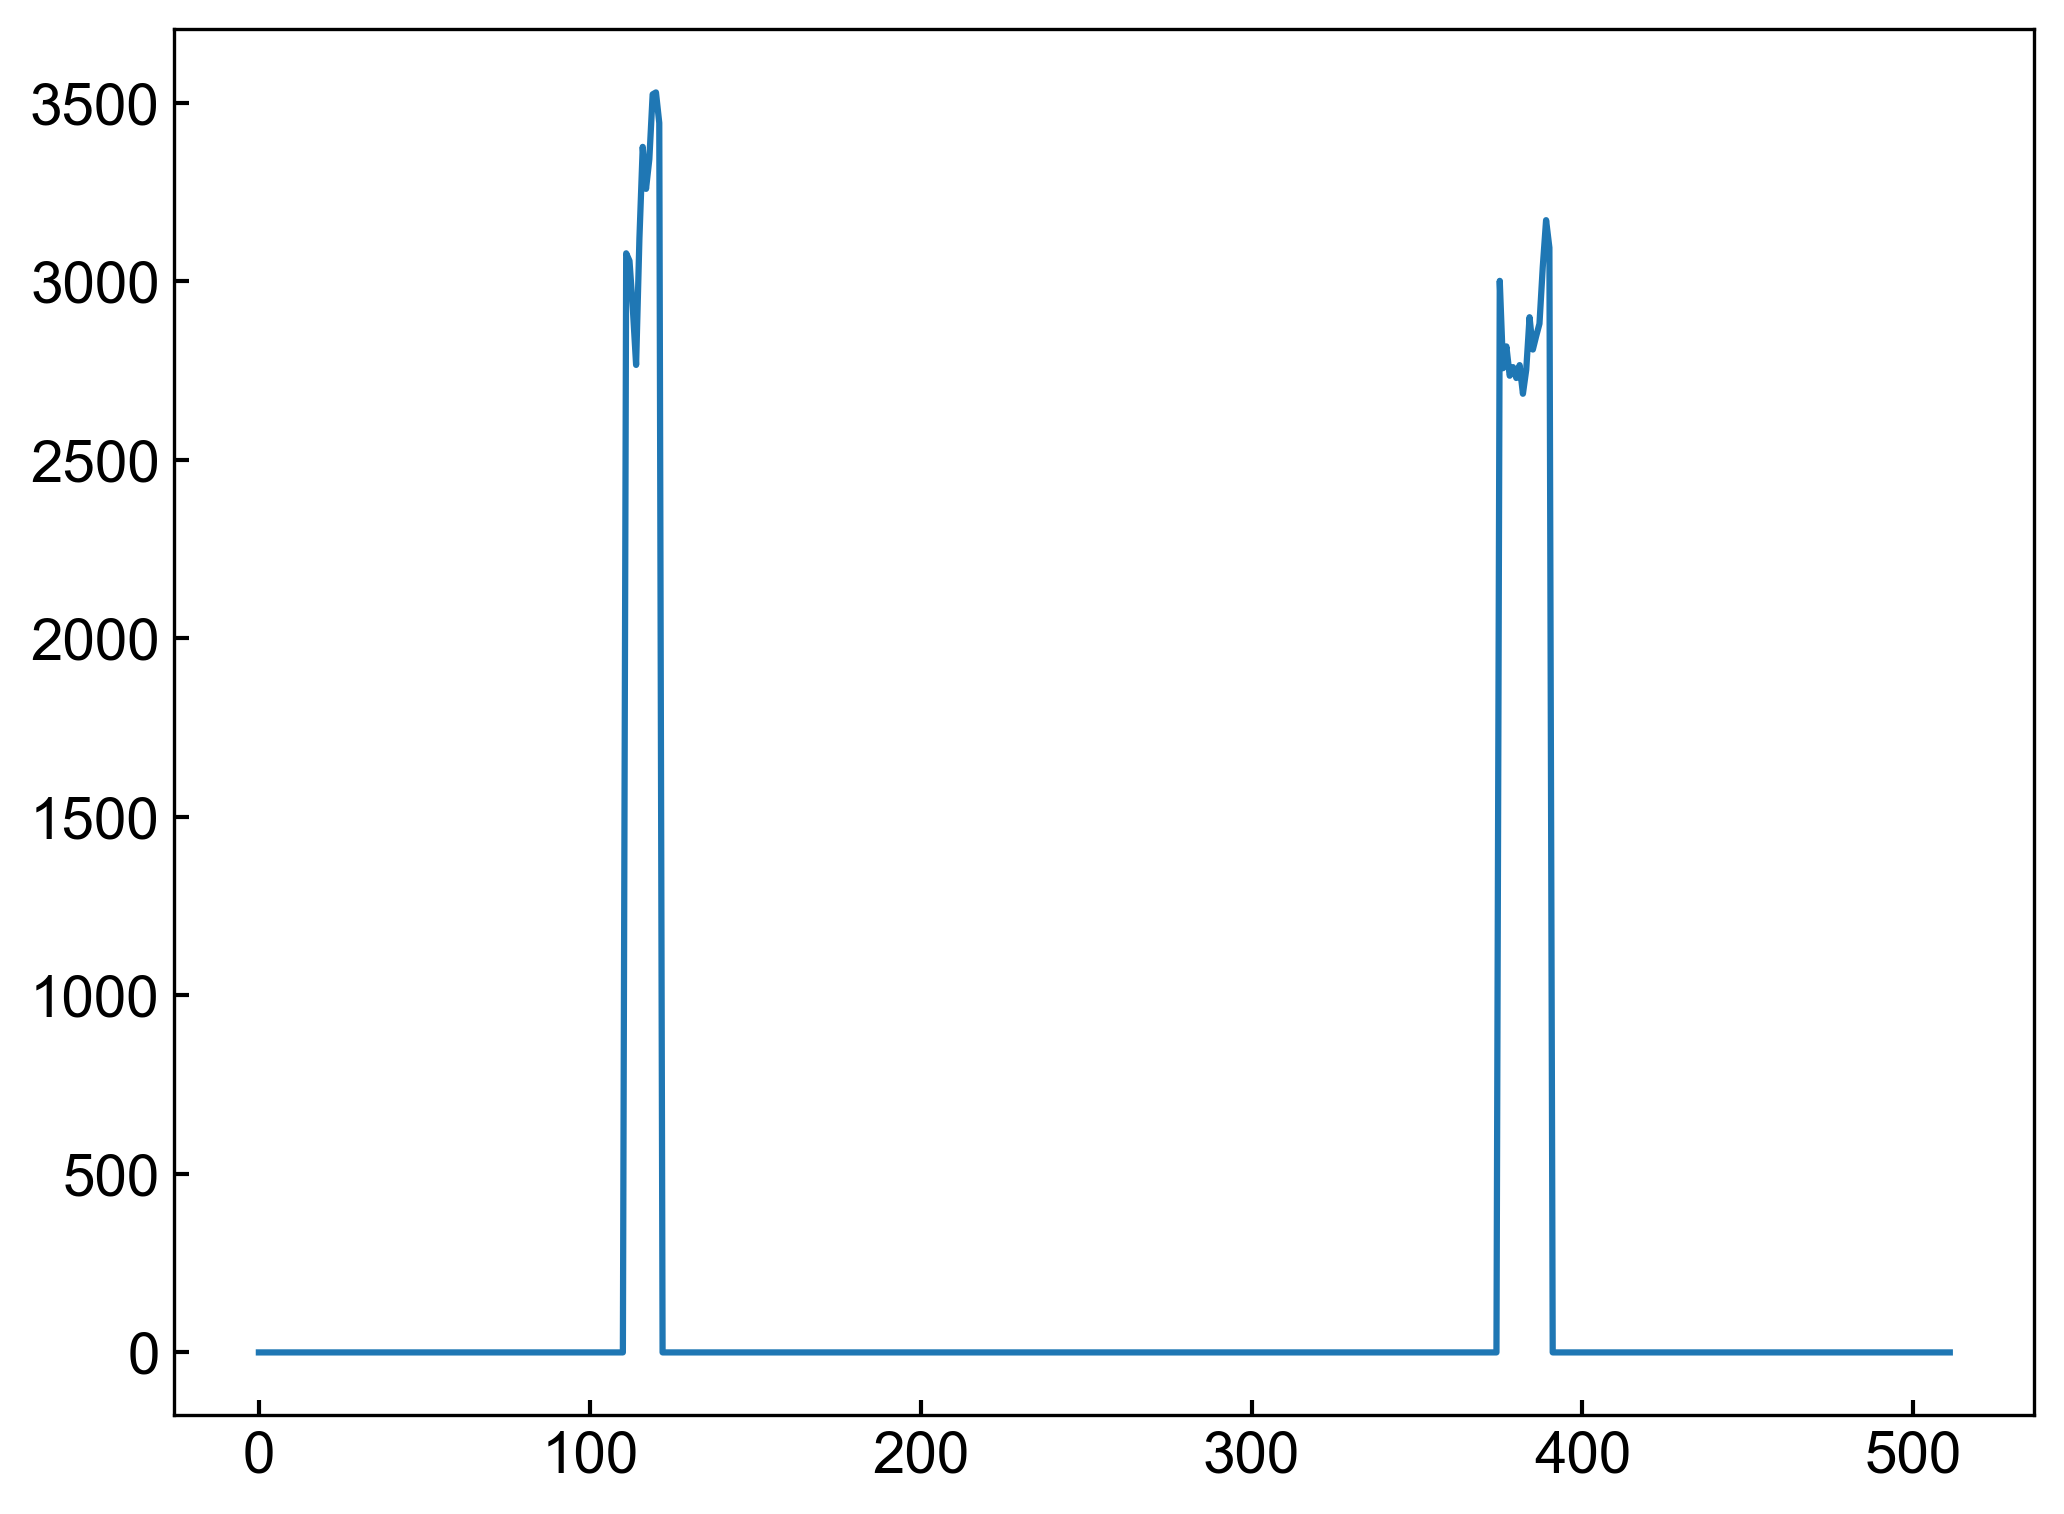

In [13]:
plt.plot(ans_dist_1.get_frame_temperature(300))

## データセット2

In [14]:
# 元の露光データ


# 上流・下流のフィルター補正値


# 較正後スペクトルデータ


# 温度分布データ



## データを辞書にまとめる

In [15]:
# 辞書に格納
test_data_dict = {
    
}

# データセット1の適当なフレームで再現

## 露光データの俯瞰

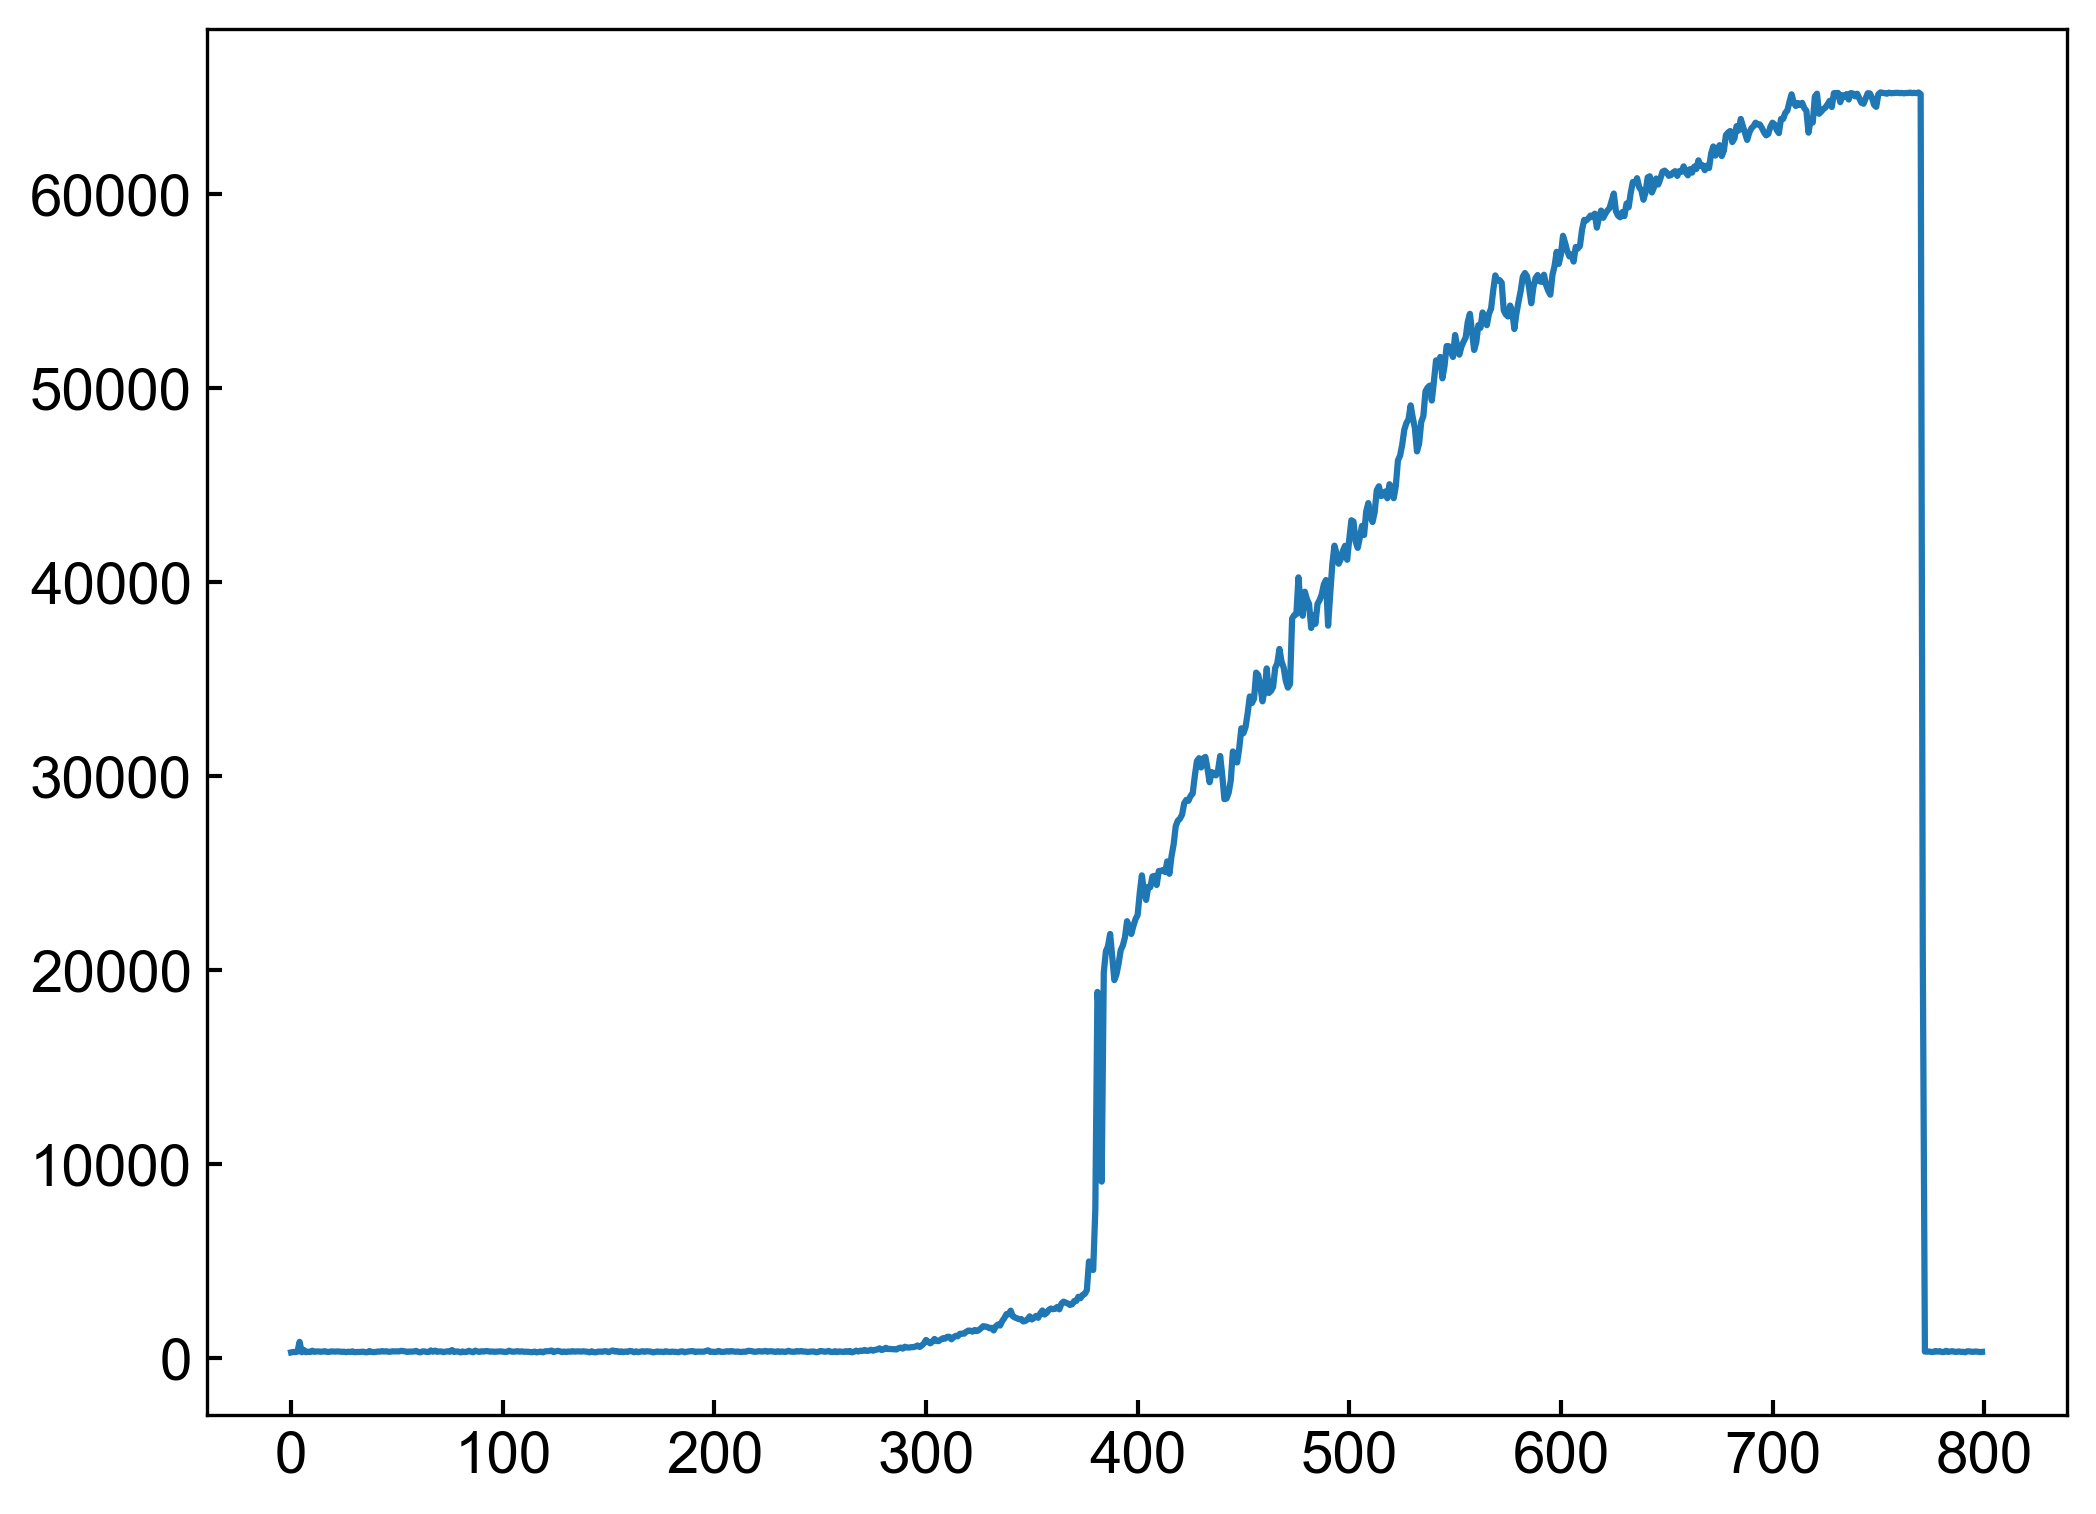

In [16]:
# 最大強度配列を可視化
plt.plot(raw_radiation_1.get_max_intensity_arr())
plt.show()
plt.close()

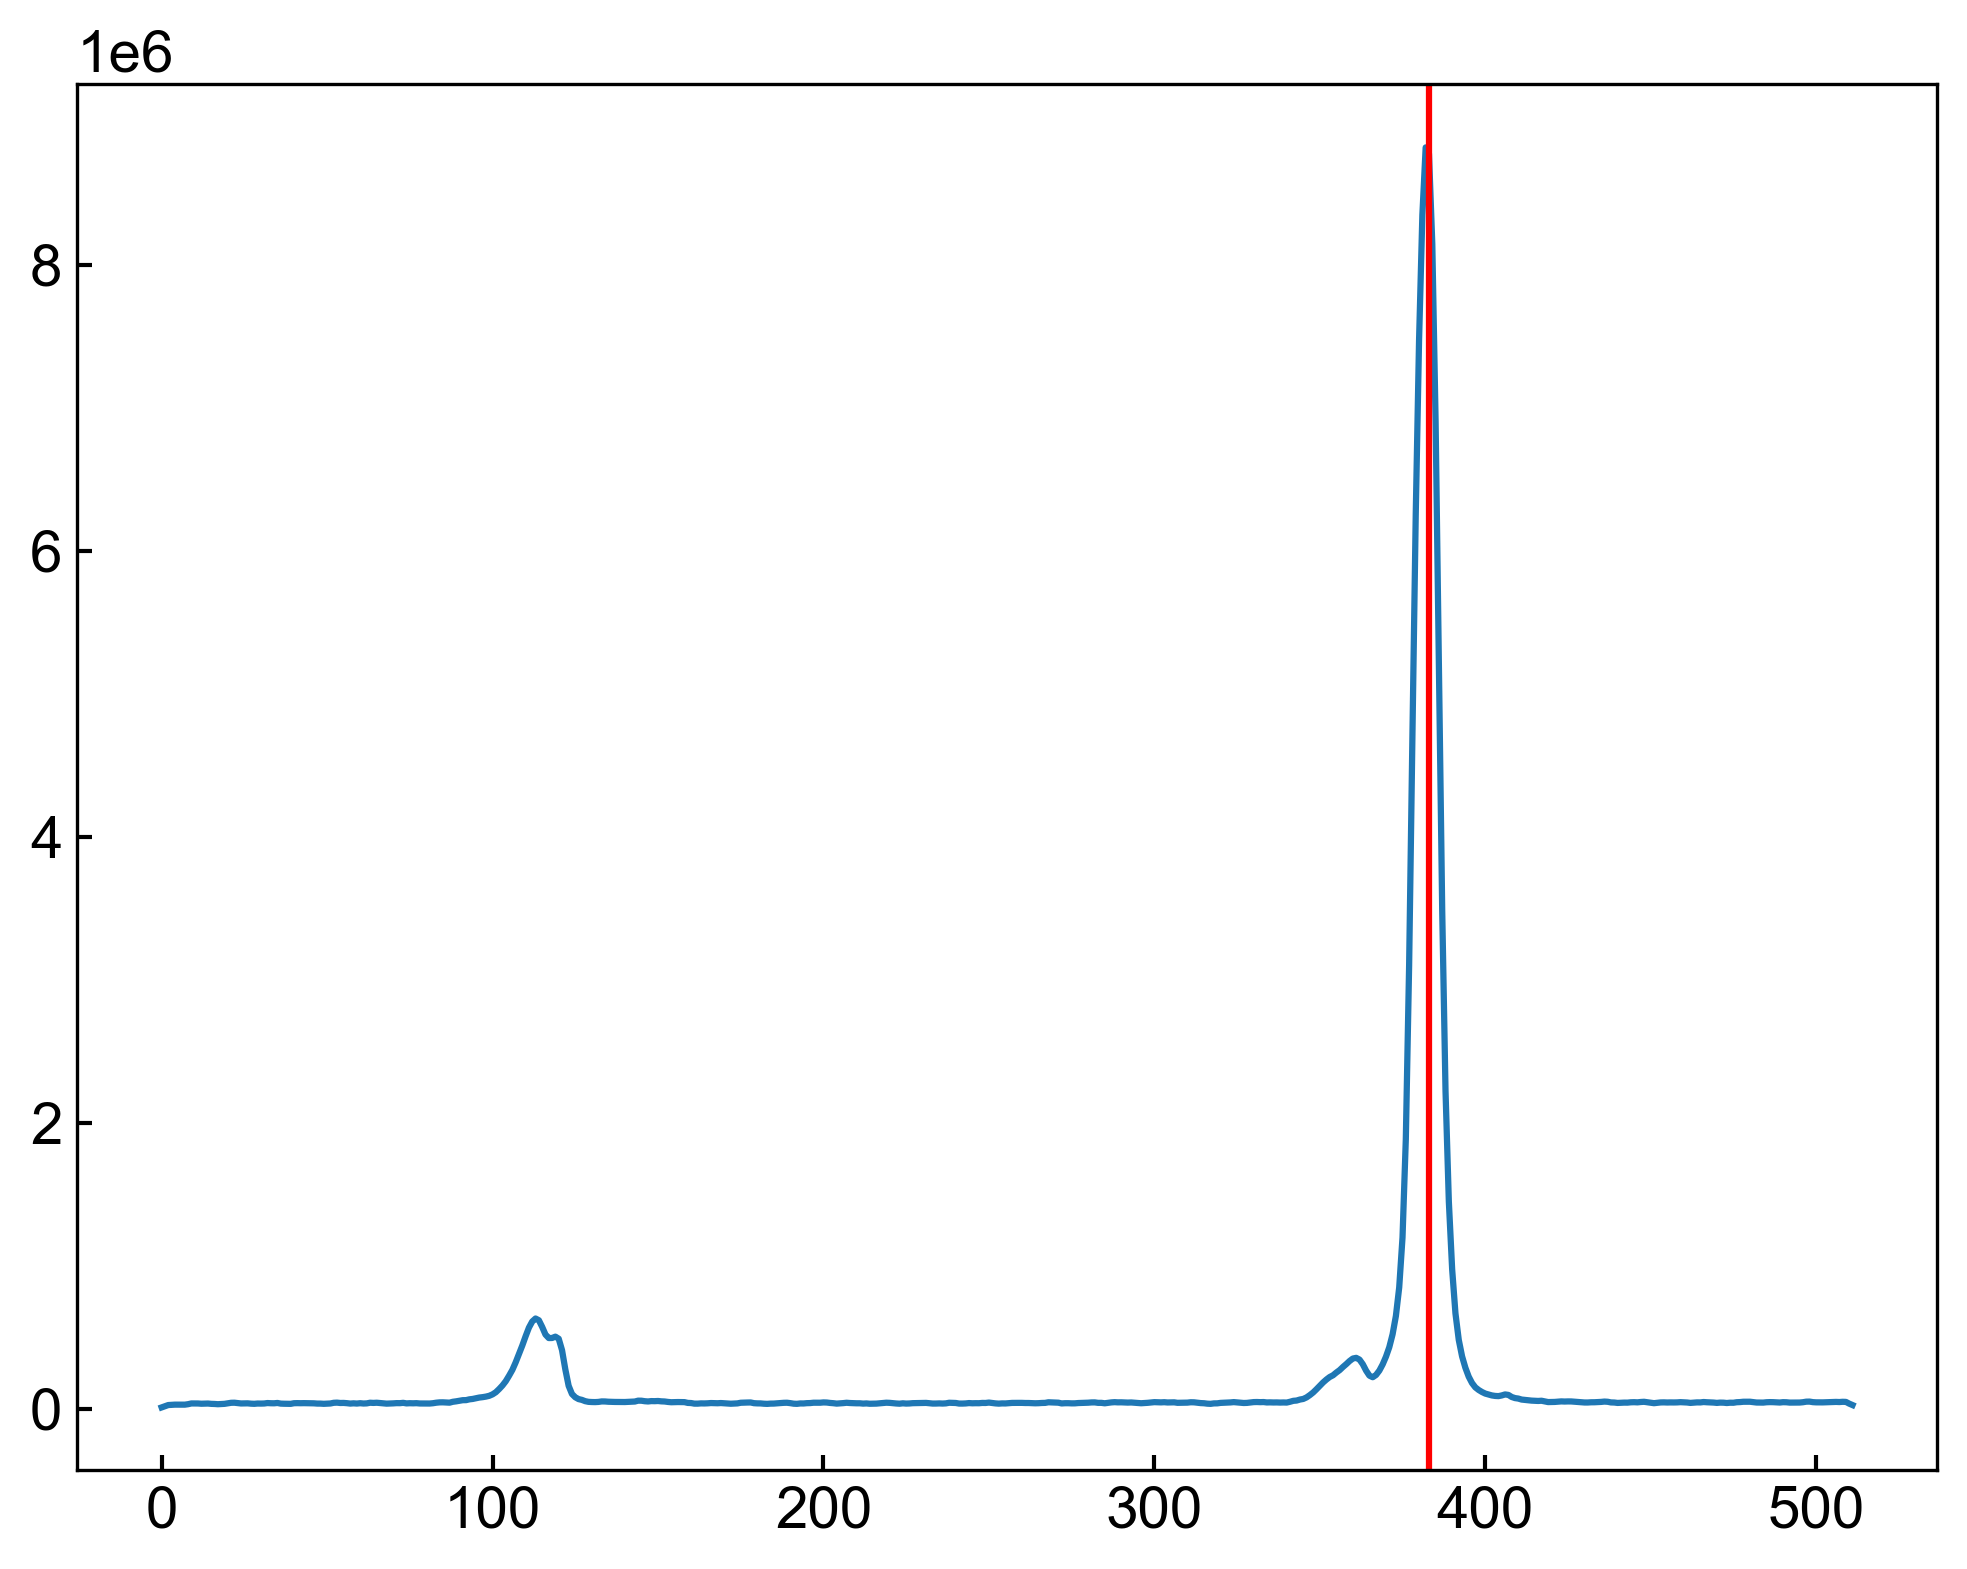

In [17]:
# 露光データ
plt.plot(raw_radiation_1.get_frame_data(500).sum(axis=1))
plt.axvline(383, color='red')
plt.show()
plt.close()

## frame, positonを設定

In [18]:
# test frameを設定
test_frame = 500

# test positionを設定
test_position = 383 # →必要なフィルターデータはdown

In [19]:
# データが大きいと長い。石澤のラップトップで80 secほど
ans_spectrum = ans_calib_1.get_spectrum(frame=test_frame, position_pixel=test_position)

In [25]:
ans_spectrum

,Wavelength,Intensity
0,438.330810,0.000000
1,439.359413,0.000000
2,440.387998,0.128331
3,441.416565,0.096255
4,442.445113,0.080520
...,...,...
507,957.266983,0.386117
508,958.285083,39.300919
509,959.303159,0.000000
510,960.321213,4.196608


In [75]:
raw_spectrum = raw_radiation_1.get_frame_data(test_frame-1)[test_position-1]
ref_intensity = ref_spectrum['intensity']
down_1_intensity = down_1.get_all_data_arr()[0][0]

In [76]:
# NumPy の補間関数を使用
ref_intensity_interpolated = np.interp(wavelength_arr, ref_spectrum['wavelength'], ref_spectrum['intensity'])

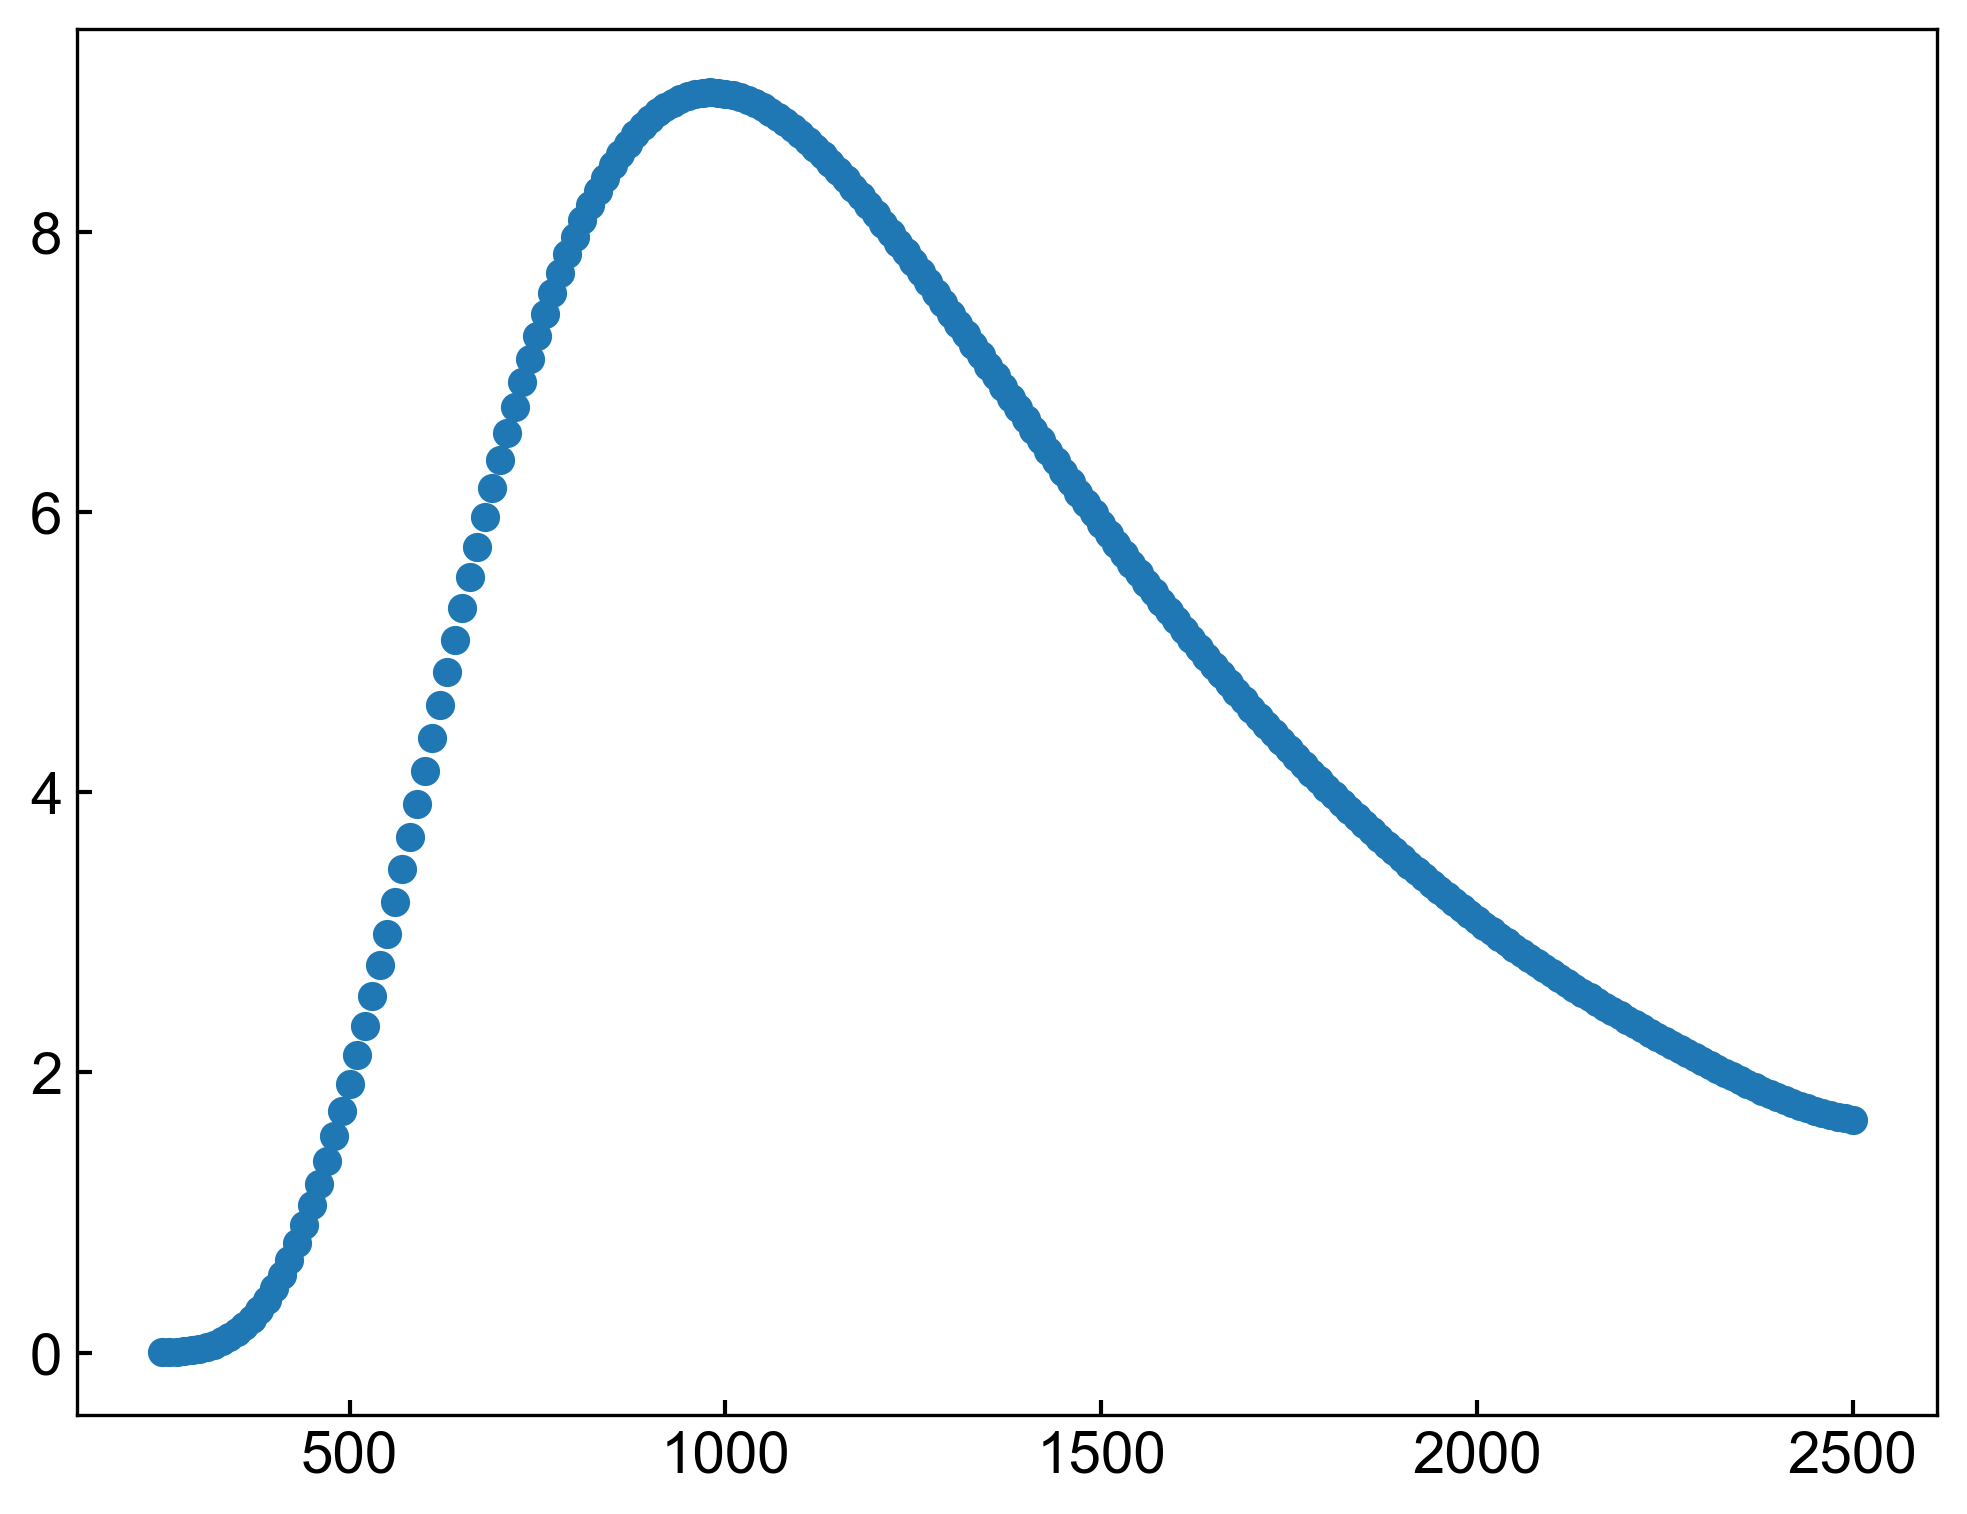

In [77]:
plt.scatter(ref_spectrum['wavelength'], ref_spectrum['intensity'])

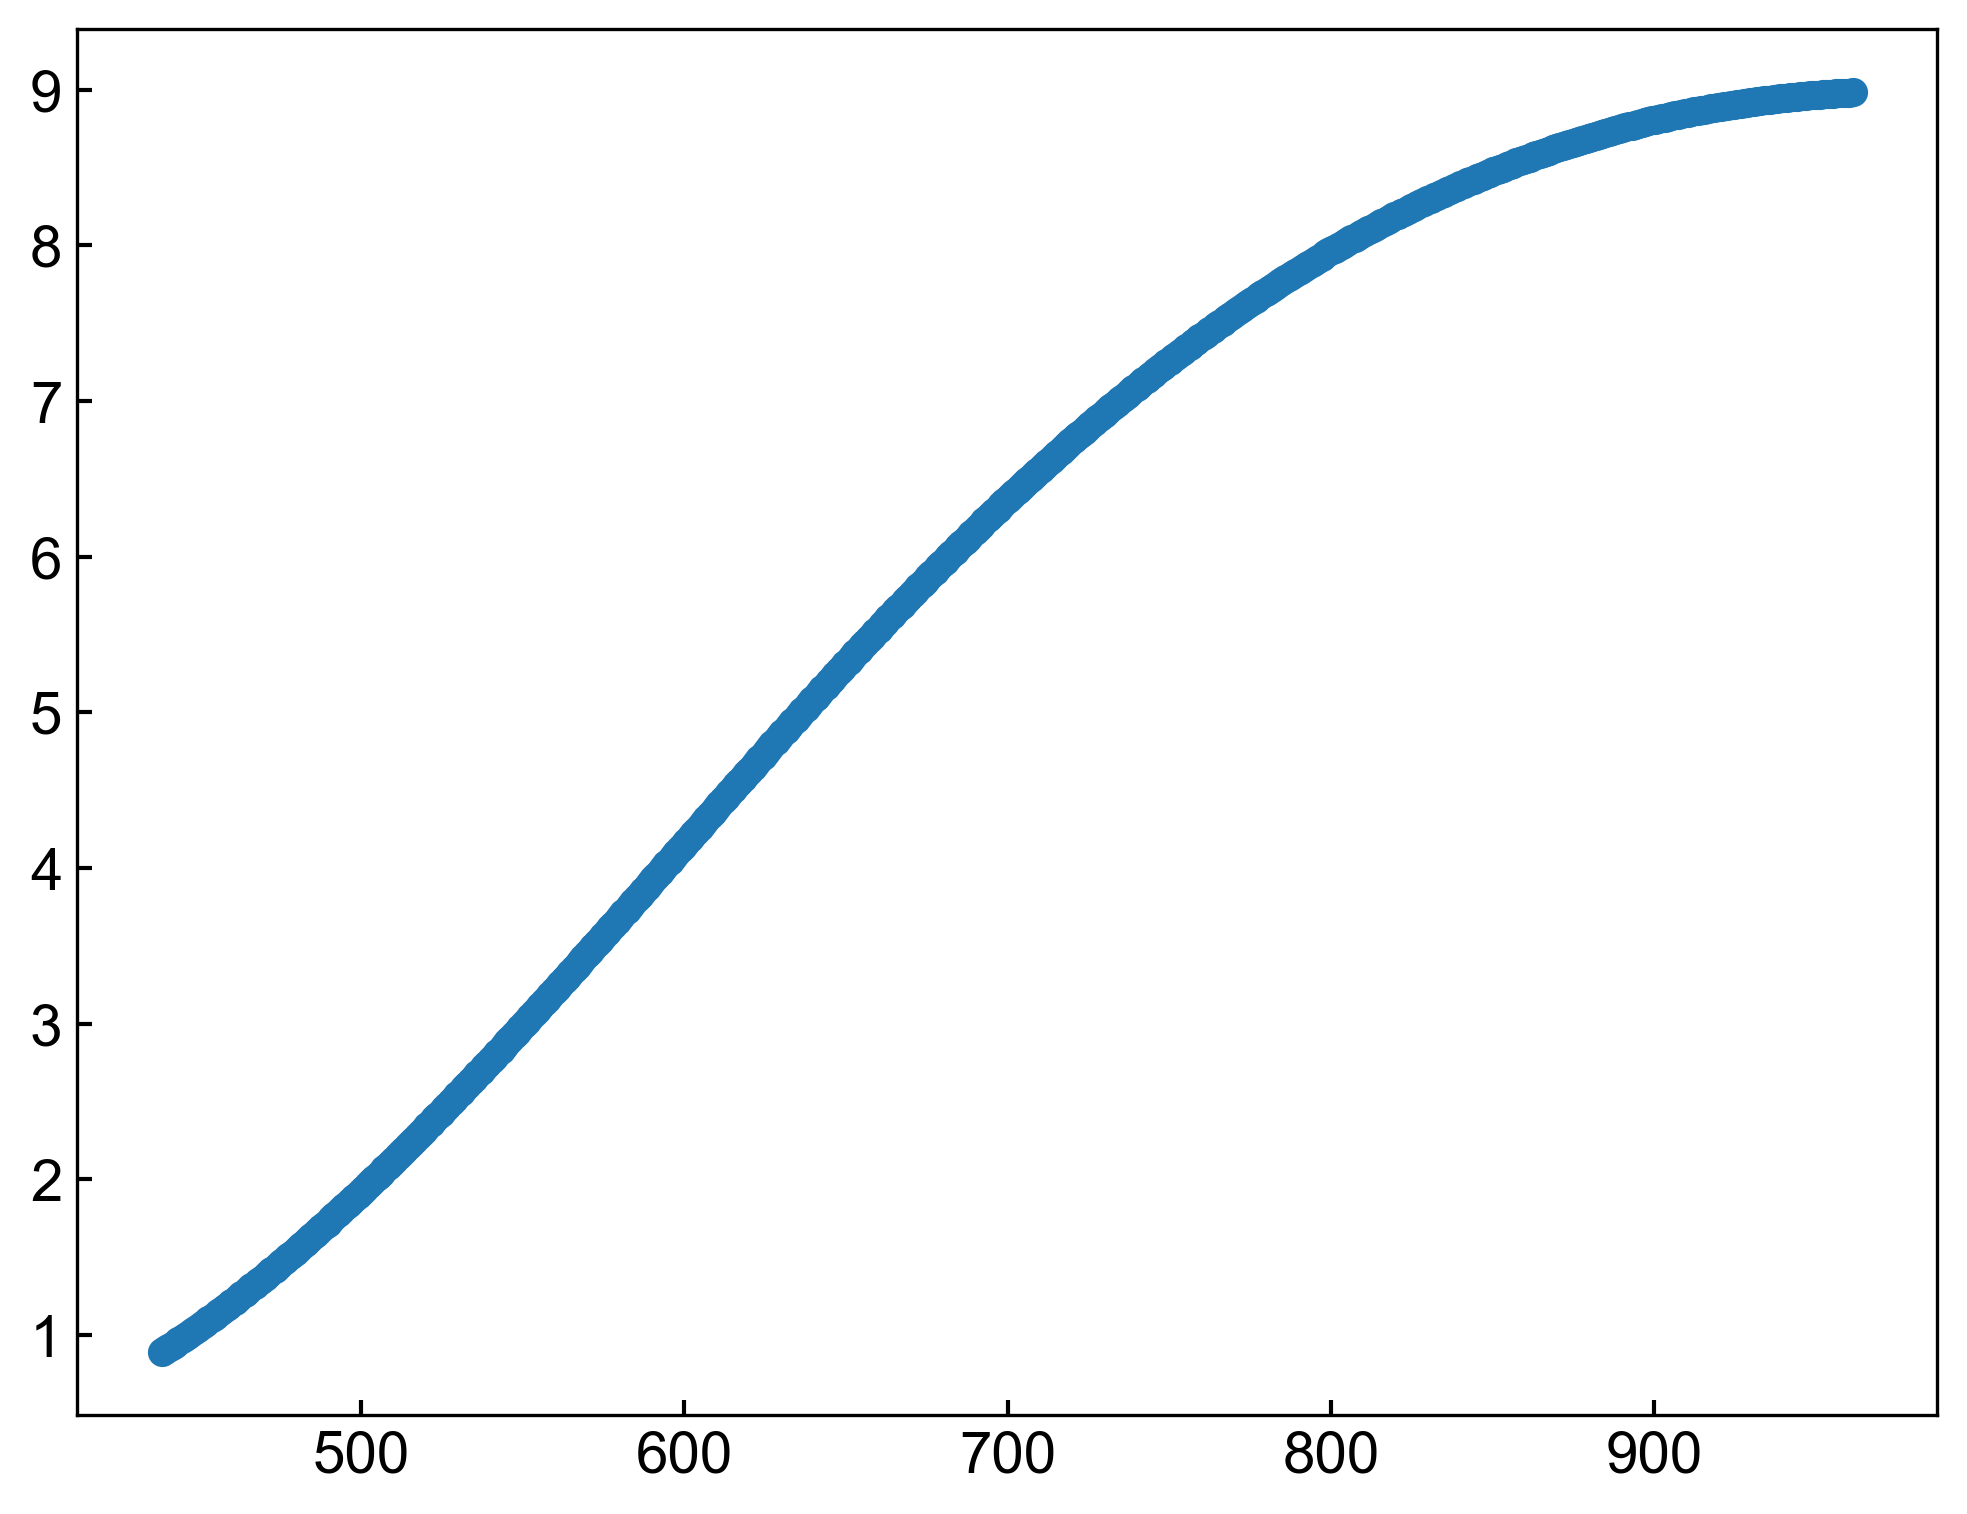

In [78]:
plt.scatter(wavelength_arr, ref_intensity_interpolated)

In [79]:
ref_spectrum

,wavelength,intensity
0,250,0.002029
1,260,0.003804
2,270,0.006722
3,280,0.011210
4,290,0.017890
...,...,...
221,2460,1.712184
222,2470,1.697810
223,2480,1.684788
224,2490,1.673168


In [80]:
ref_intensity / raw_spectrum

ValueError: operands could not be broadcast together with shapes (226,) (512,) 

In [ ]:
# 可視化して確認
fig, axes = plt.subplots(1, 4, figsize=(10, 2))

axes[0].plot(raw_spectrum)
axes[0].set_title('Raw Spectrum', fontsize='x-small')
axes[1].plot(ref_intensity)
axes[1].set_title('Reference Spectrum', fontsize='x-small')
axes[2].plot(down_1_intensity)
axes[2].set_title('Down Spectrum', fontsize='x-small')
axes[3].plot(ans_spectrum['Intensity'])
axes[3].set_title('Ans Spectrum', fontsize='x-small')
axes[3].set_ylim(0, 0.2)

plt.show()
plt.close()

## 補正

In [ ]:
# フィルター補正
plt.plot(raw_spectrum / down_1_intensity)

plt.ylim(0, 0.2)
plt.show()
plt.close()

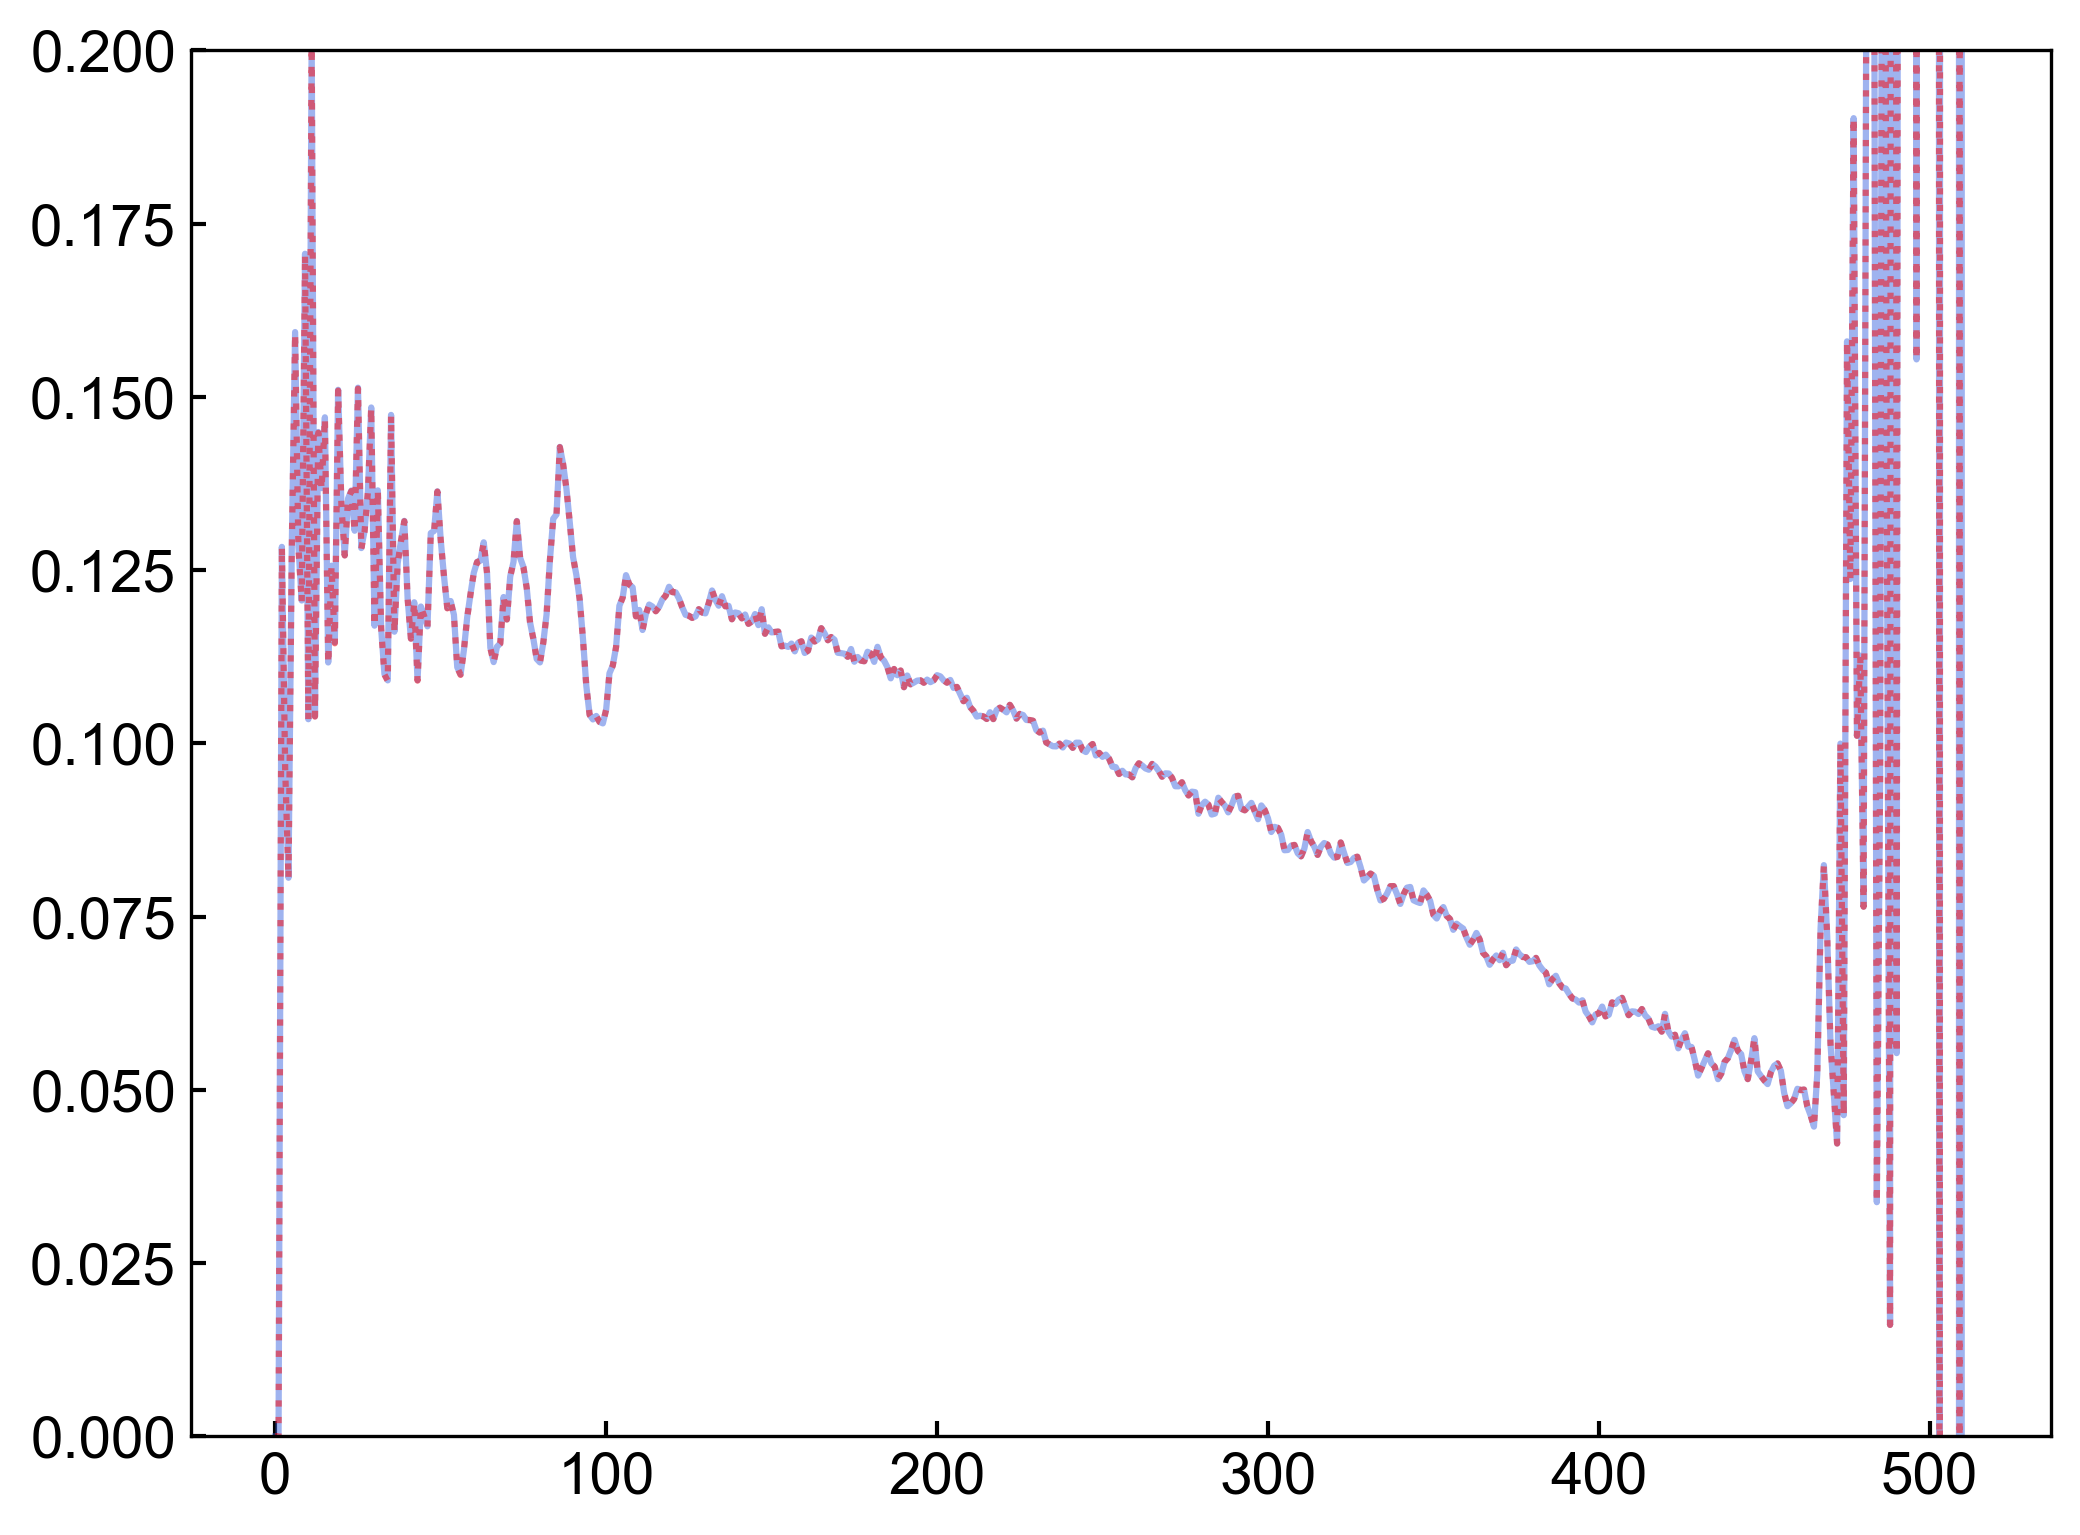

In [85]:
# 計算
plt.plot(ref_intensity_interpolated * raw_spectrum / down_1_intensity, color='royalblue', alpha=0.5)
plt.plot(ans_spectrum['Intensity'], color='red', alpha=0.5, linestyle=':')

plt.ylim(0, 0.2)
plt.show()
plt.close()


In [90]:
calculated_spectrum = ref_intensity_interpolated * raw_spectrum / down_1_intensity

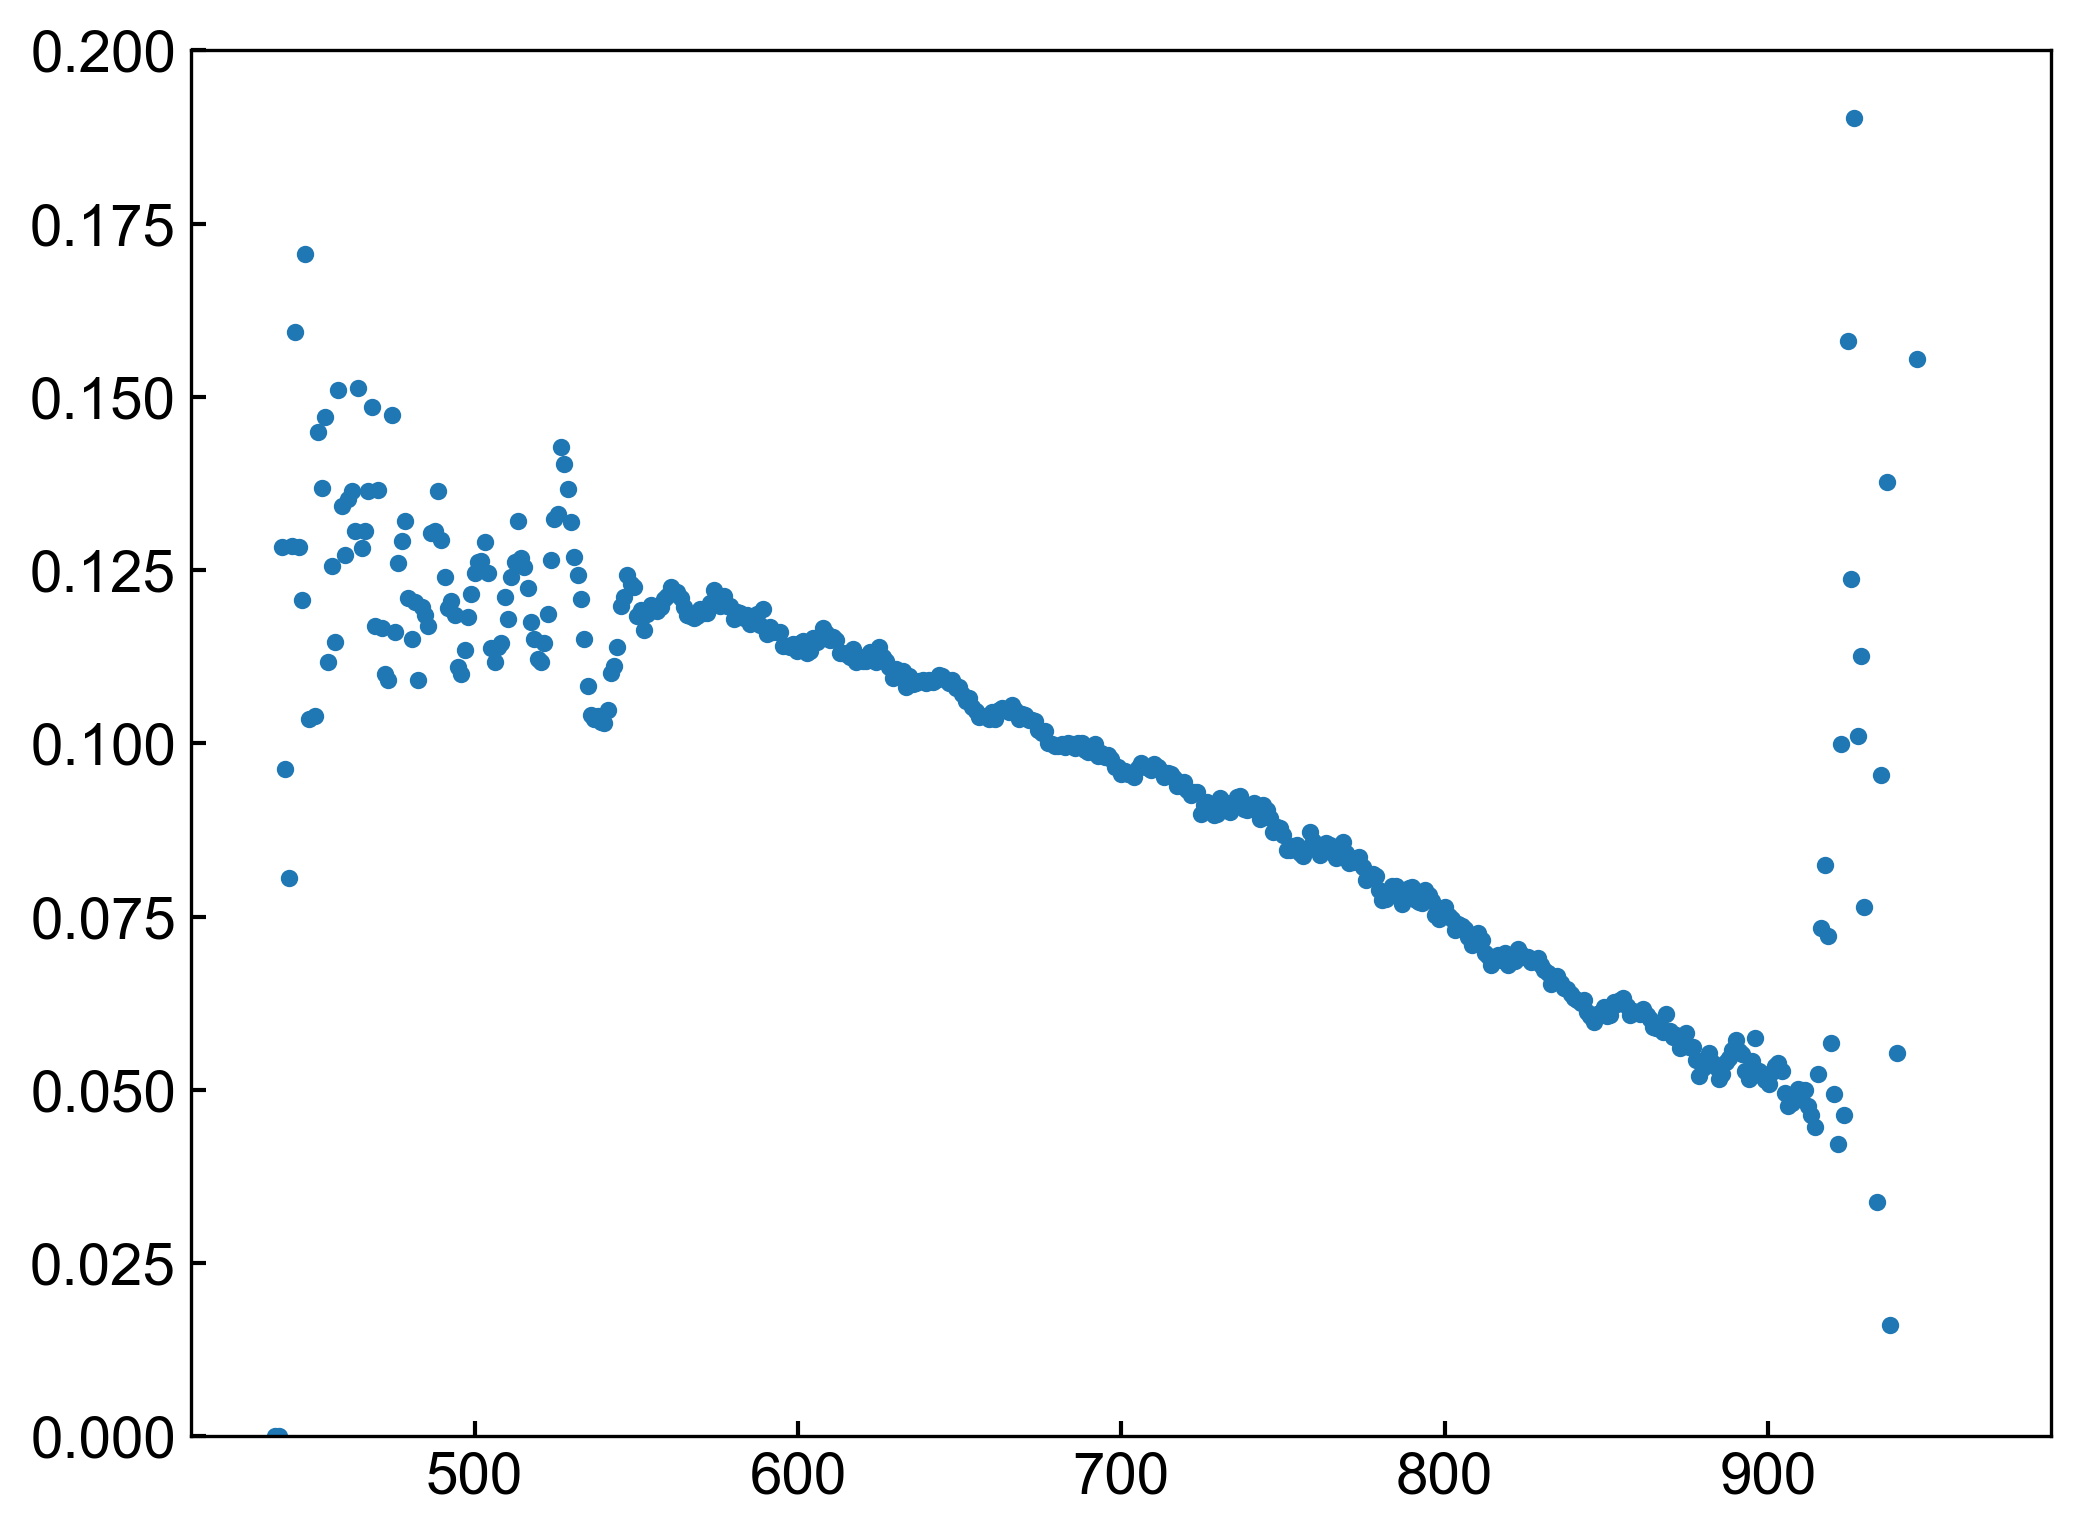

In [206]:
plt.scatter(wavelength_arr, calculated_spectrum, s=10)
plt.ylim(0, 0.2)
plt.show()
plt.close()

## 温度の計算

### プランク関数によるfitting

In [94]:
# PlanckThermometerの結果の温度
ans_dist_1.get_frame_temperature(test_frame)[test_position]

np.float64(5974.4326171875)

In [105]:
# プランク関数の定義
def planck_function(wavelength, T, A):
    """
    wavelength: 波長 (nm単位), T: 温度 (K), A: スケール因子
    """
    wavelength_m = wavelength * 1e-9  # nm -> m
    intensity = (2 * h * c**2) / (wavelength_m**5) * (1 / (np.exp((h * c) / (wavelength_m * k * T)) - 1))
    return A * intensity


In [120]:
# 波長範囲を 600-800 nm に制限
mask = (wavelength_arr >= 600) & (wavelength_arr <= 800)
wavelength_fit = wavelength_arr[mask]
intensity_fit = calculated_spectrum[mask]

# フィッティング実行
initial_temperature = 3000  # 初期温度を 3000 K に設定
initial_scale = 1e-6        # 初期スケール因子を適当に設定
params, covariance = curve_fit(planck_function, wavelength_fit, intensity_fit, p0=[initial_temperature, initial_scale])

# フィッティング結果と標準誤差
fitted_temperature, fitted_scale = params
temperature_error, scale_error = np.sqrt(np.diag(covariance))

print(f"フィッティングされた温度: {fitted_temperature:.2f} K ± {temperature_error:.2f} K")
print(f"フィッティングされたスケール因子: {fitted_scale:.2e} ± {scale_error:.2e}")


フィッティングされた温度: 6000.30 K ± 22.30 K
フィッティングされたスケール因子: 4.06e-15 ± 5.49e-17


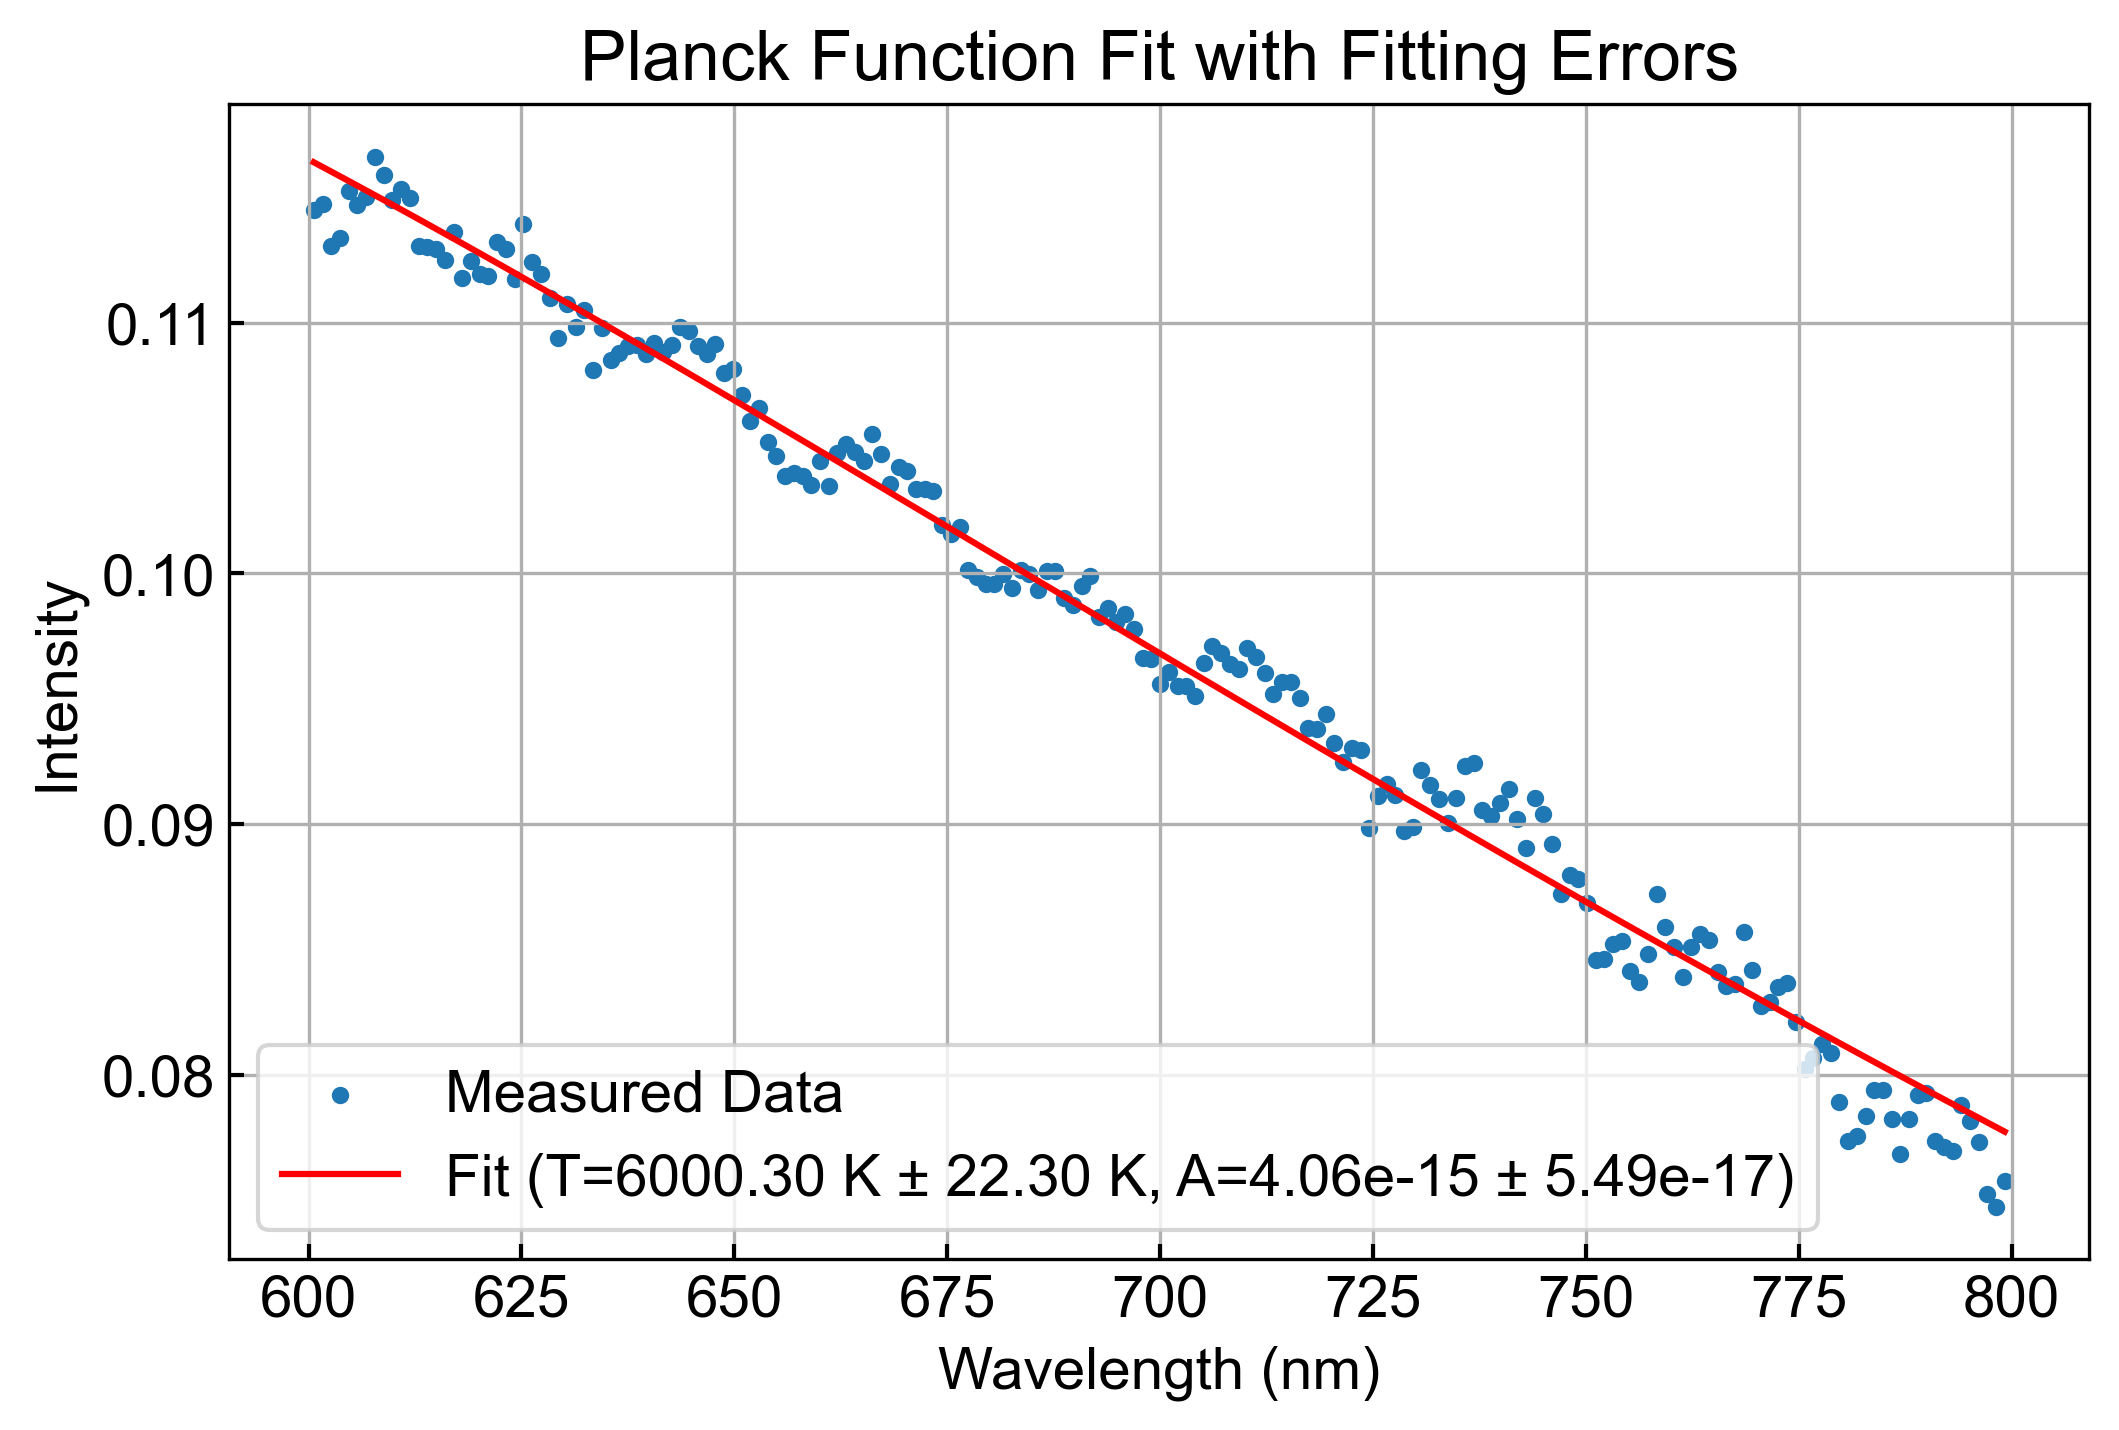

In [123]:

# フィッティング結果のプロット
plt.figure(figsize=(8, 5))
plt.scatter(wavelength_fit, intensity_fit, label='Measured Data', s=10)
plt.plot(wavelength_fit, planck_function(wavelength_fit, fitted_temperature, fitted_scale), 'r-', label=f'Fit (T={fitted_temperature:.2f} K ± {temperature_error:.2f} K, A={fitted_scale:.2e} ± {scale_error:.2e})')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.legend()
plt.title('Planck Function Fit with Fitting Errors')
plt.grid(True)
plt.show()


### 二色法による計算

In [146]:
print(pd.DataFrame(wavelength_fit, intensity_fit))

                   0
0.114503  600.614340
0.114739  601.639904
0.113052  602.665447
0.113382  603.690971
0.115275  604.716475
...              ...
0.078156  795.104204
0.077302  796.125831
0.075261  797.147436
0.074735  798.169019
0.075781  799.190582

[195 rows x 1 columns]


In [175]:

from scipy.optimize import fsolve

# equation_to_solve 関数を定義
def equation_to_solve(T, lambda1, lambda2, R):
    """
    強度比 R の式から温度を求めるための方程式
    
    Parameters:
    ----------
    T : float
        温度 (K)
    lambda1 : float
        波長1 (nm)
    lambda2 : float
        波長2 (nm)
    R : float
        強度比 R = I(lambda1) / I(lambda2)
    
    Returns:
    -------
    difference : float
        左辺と右辺の差（ゼロに近い値を探す）
    """
    # 波長をメートル単位に変換
    lambda1_m = lambda1 * 1e-9
    lambda2_m = lambda2 * 1e-9

    # 分子と分母を計算
    numerator = lambda2_m**5 * (np.exp(h * c / (lambda2_m * k * T)) - 1)
    denominator = lambda1_m**5 * (np.exp(h * c / (lambda1_m * k * T)) - 1)

    # 強度比を計算
    R_calculated = numerator / denominator

    # 左辺と右辺の差を返す
    return R_calculated - R


def calculate_temperature_all_pairs(wavelength_fit, intensity_fit):
    """
    波長の大小関係を満たすすべてのペアに対して温度を数値的に解き、警告が発生したペアを記録
    
    Parameters:
    ----------
    wavelength_fit : ndarray
        波長の配列（nm単位）
    intensity_fit : ndarray
        強度の配列
    
    Returns:
    -------
    temperatures : list of floats
        各ペアに対応する温度のリスト
    warning_pairs : list of tuples
        警告が発生した波長ペアのリスト
    """
    temperatures = []
    warning_pairs = []  # 警告が発生したペアを記録
    n = len(wavelength_fit)

    for i in range(n):
        for j in range(i + 1, n):
            lambda1 = wavelength_fit[i]
            lambda2 = wavelength_fit[j]
            I1 = intensity_fit[i]
            I2 = intensity_fit[j]

            # 強度比 R を計算
            R = I1 / I2

            # 初期値を仮定
            T_initial_guess = 6000  # K

            # 警告をキャッチしながら数値解を求める
            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always")  # すべての警告をキャッチ

                try:
                    T_solution = fsolve(equation_to_solve, T_initial_guess, args=(lambda1, lambda2, R))[0]
                    temperatures.append(T_solution)

                    # 警告が発生した場合、そのペアを記録
                    if w:
                        warning_pairs.append((lambda1, lambda2))

                except Exception as e:
                    # 例外が発生した場合もペアを記録
                    warning_pairs.append((lambda1, lambda2))

    return np.array(temperatures), warning_pairs

def plot_warning_pairs(warning_pairs):
    """
    警告が発生した波長ペアを散布図で可視化
    
    Parameters:
    ----------
    warning_pairs : list of tuples
        警告が発生した波長ペアのリスト [(lambda1, lambda2), ...]
    """
    if not warning_pairs:
        print("警告が発生したペアはありません。")
        return
    
    # 警告ペアの波長を抽出
    lambda1_vals, lambda2_vals = zip(*warning_pairs)
    
    # 散布図を作成
    plt.figure(figsize=(8, 6))
    plt.scatter(lambda1_vals, lambda2_vals, c='red', alpha=0.6, edgecolor='black')
    plt.xlabel("Wavelength 1 (nm)")
    plt.ylabel("Wavelength 2 (nm)")
    plt.title("Warning Pairs Scatter Plot")
    plt.grid(True)
    plt.show()

def plot_warning_heatmap(warning_pairs, bin_size=10):
    """
    警告が発生した波長ペアをヒートマップで可視化
    
    Parameters:
    ----------
    warning_pairs : list of tuples
        警告が発生した波長ペアのリスト [(lambda1, lambda2), ...]
    bin_size : int
        波長を区切るビンのサイズ
    """
    if not warning_pairs:
        print("警告が発生したペアはありません。")
        return
    
    # 波長範囲を取得
    lambda1_vals, lambda2_vals = zip(*warning_pairs)
    lambda_min = int(min(min(lambda1_vals), min(lambda2_vals)))
    lambda_max = int(max(max(lambda1_vals), max(lambda2_vals)))
    
    # 波長をビンに分けてヒートマップの行列を作成
    bins = np.arange(lambda_min, lambda_max + bin_size, bin_size)
    heatmap, xedges, yedges = np.histogram2d(lambda1_vals, lambda2_vals, bins=(bins, bins))
    
    # ヒートマップをプロット
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap.T, cmap='Reds', cbar=True, xticklabels=bins, yticklabels=bins)
    plt.xlabel("Wavelength 1 (nm)")
    plt.ylabel("Wavelength 2 (nm)")
    plt.title("Warning Pairs Heatmap")
    plt.show()

In [176]:
# 温度を計算
temperatures, warning_pairs = calculate_temperature_all_pairs(wavelength_fit, intensity_fit)
temperatures = temperatures[
    (temperatures > 1_000) & (temperatures < 10_000)
]

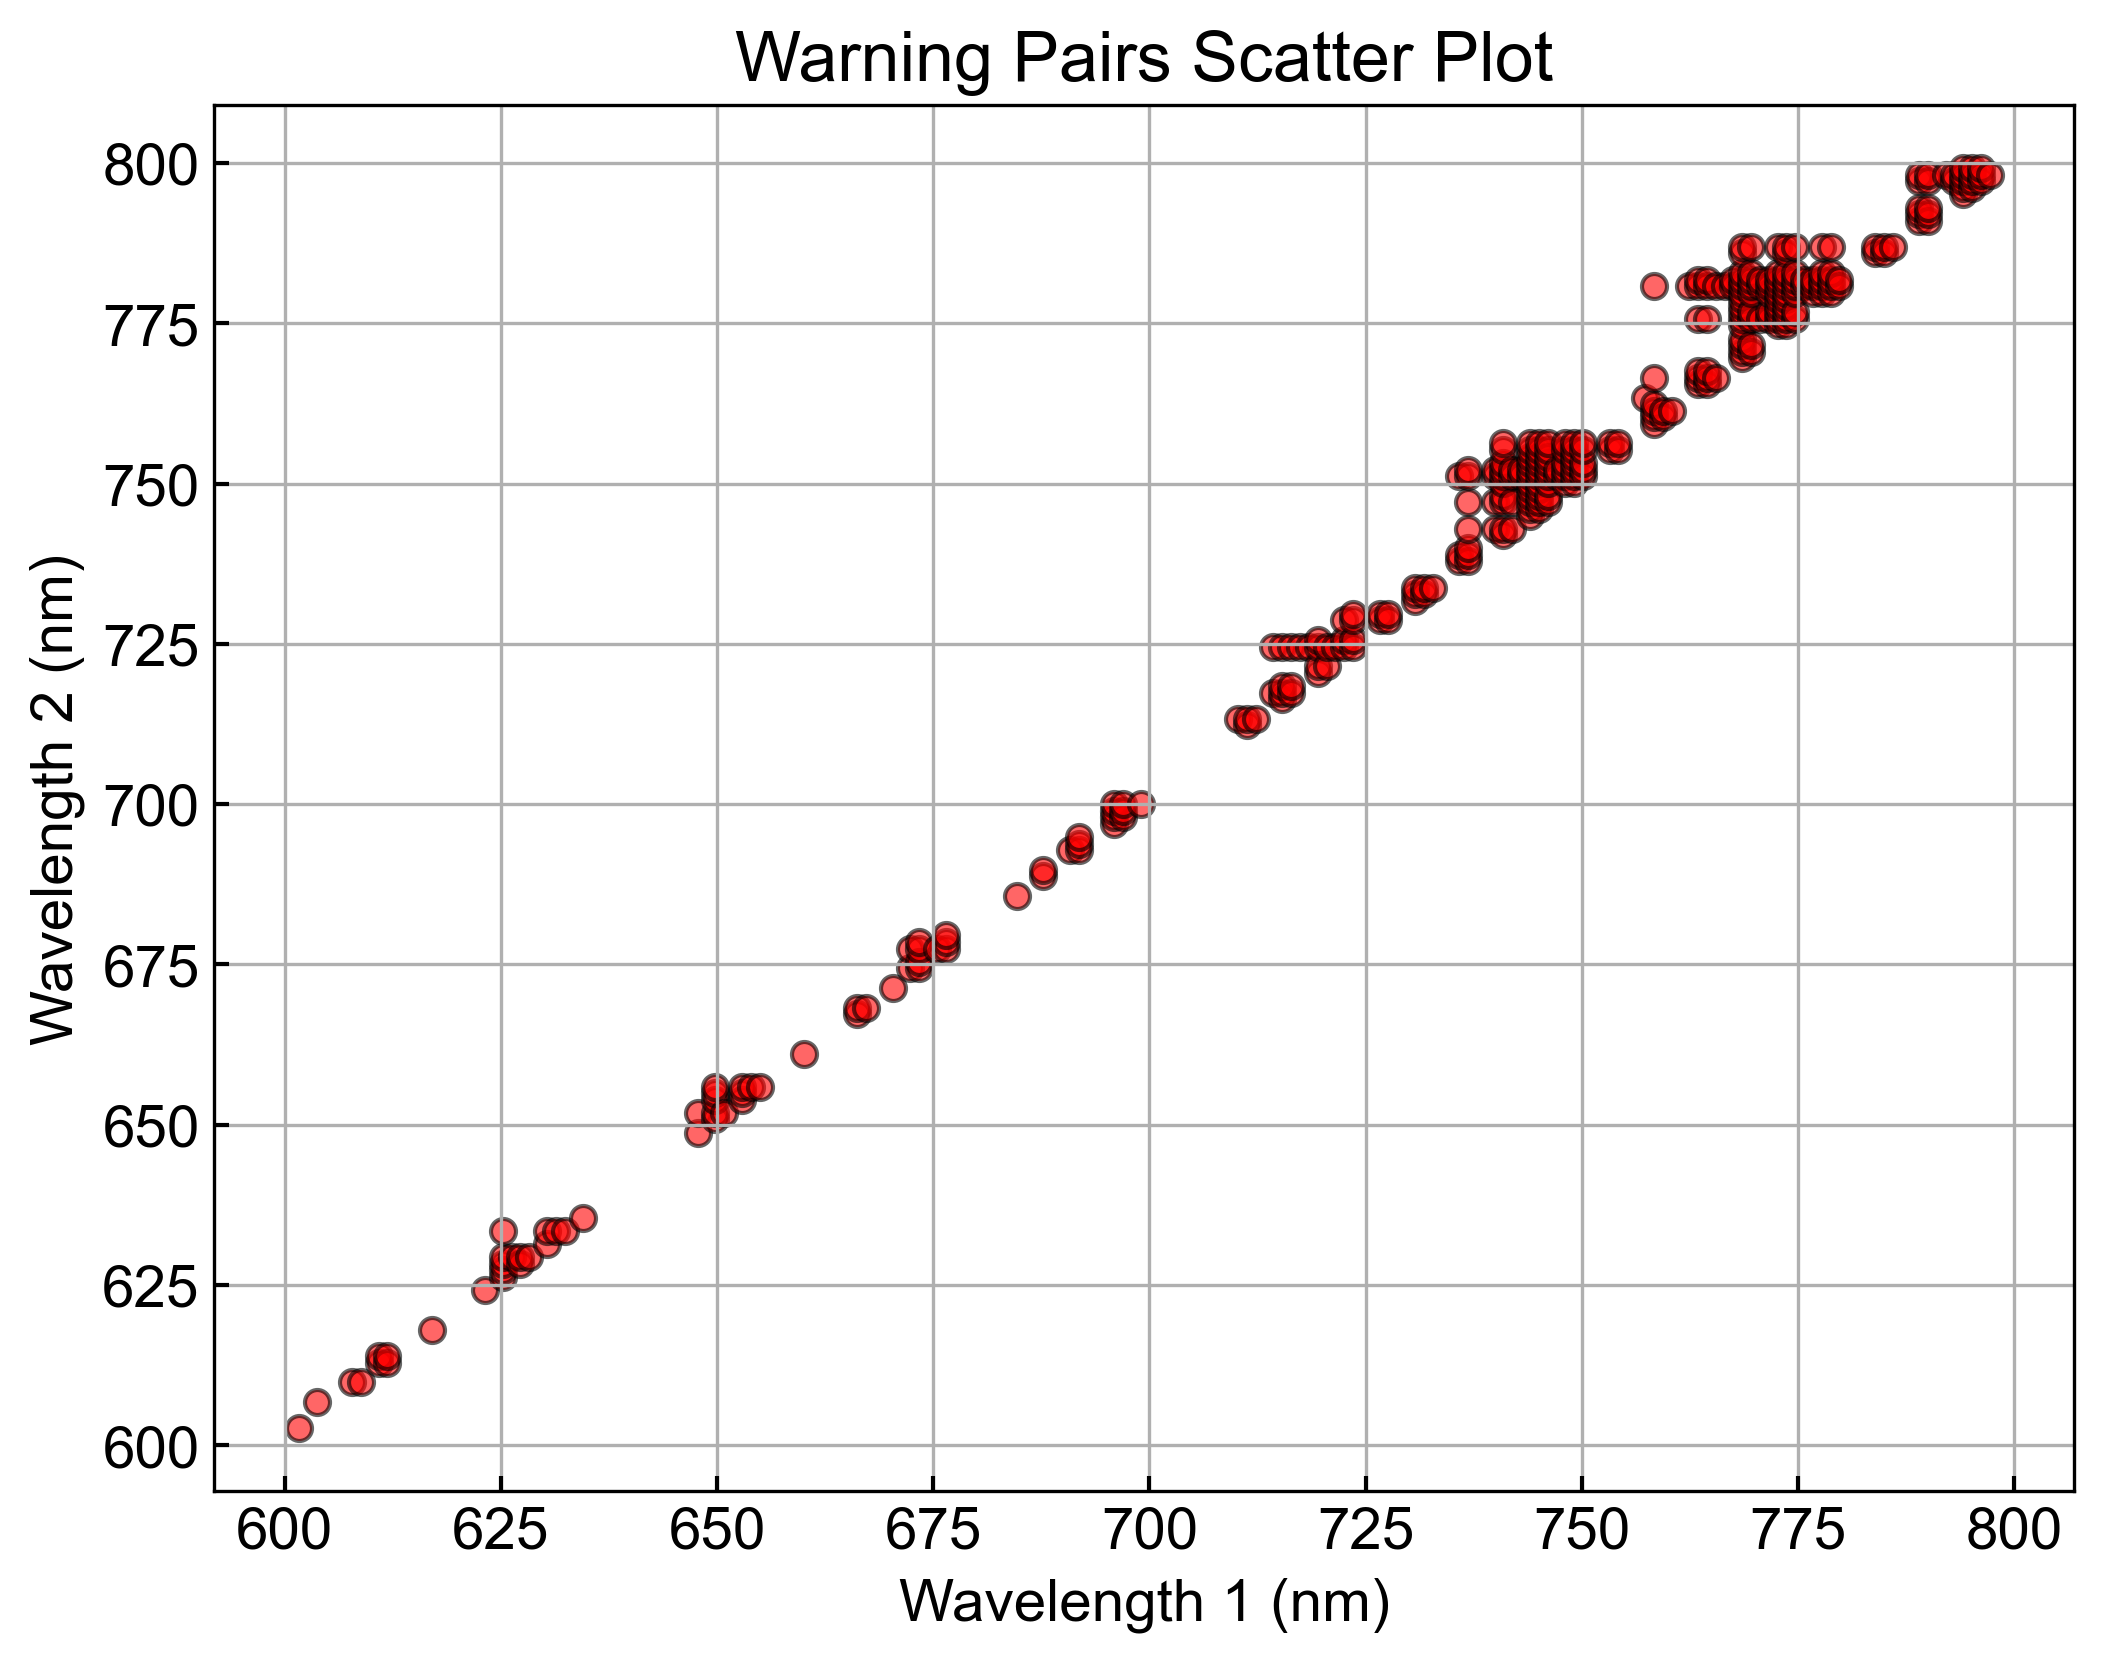

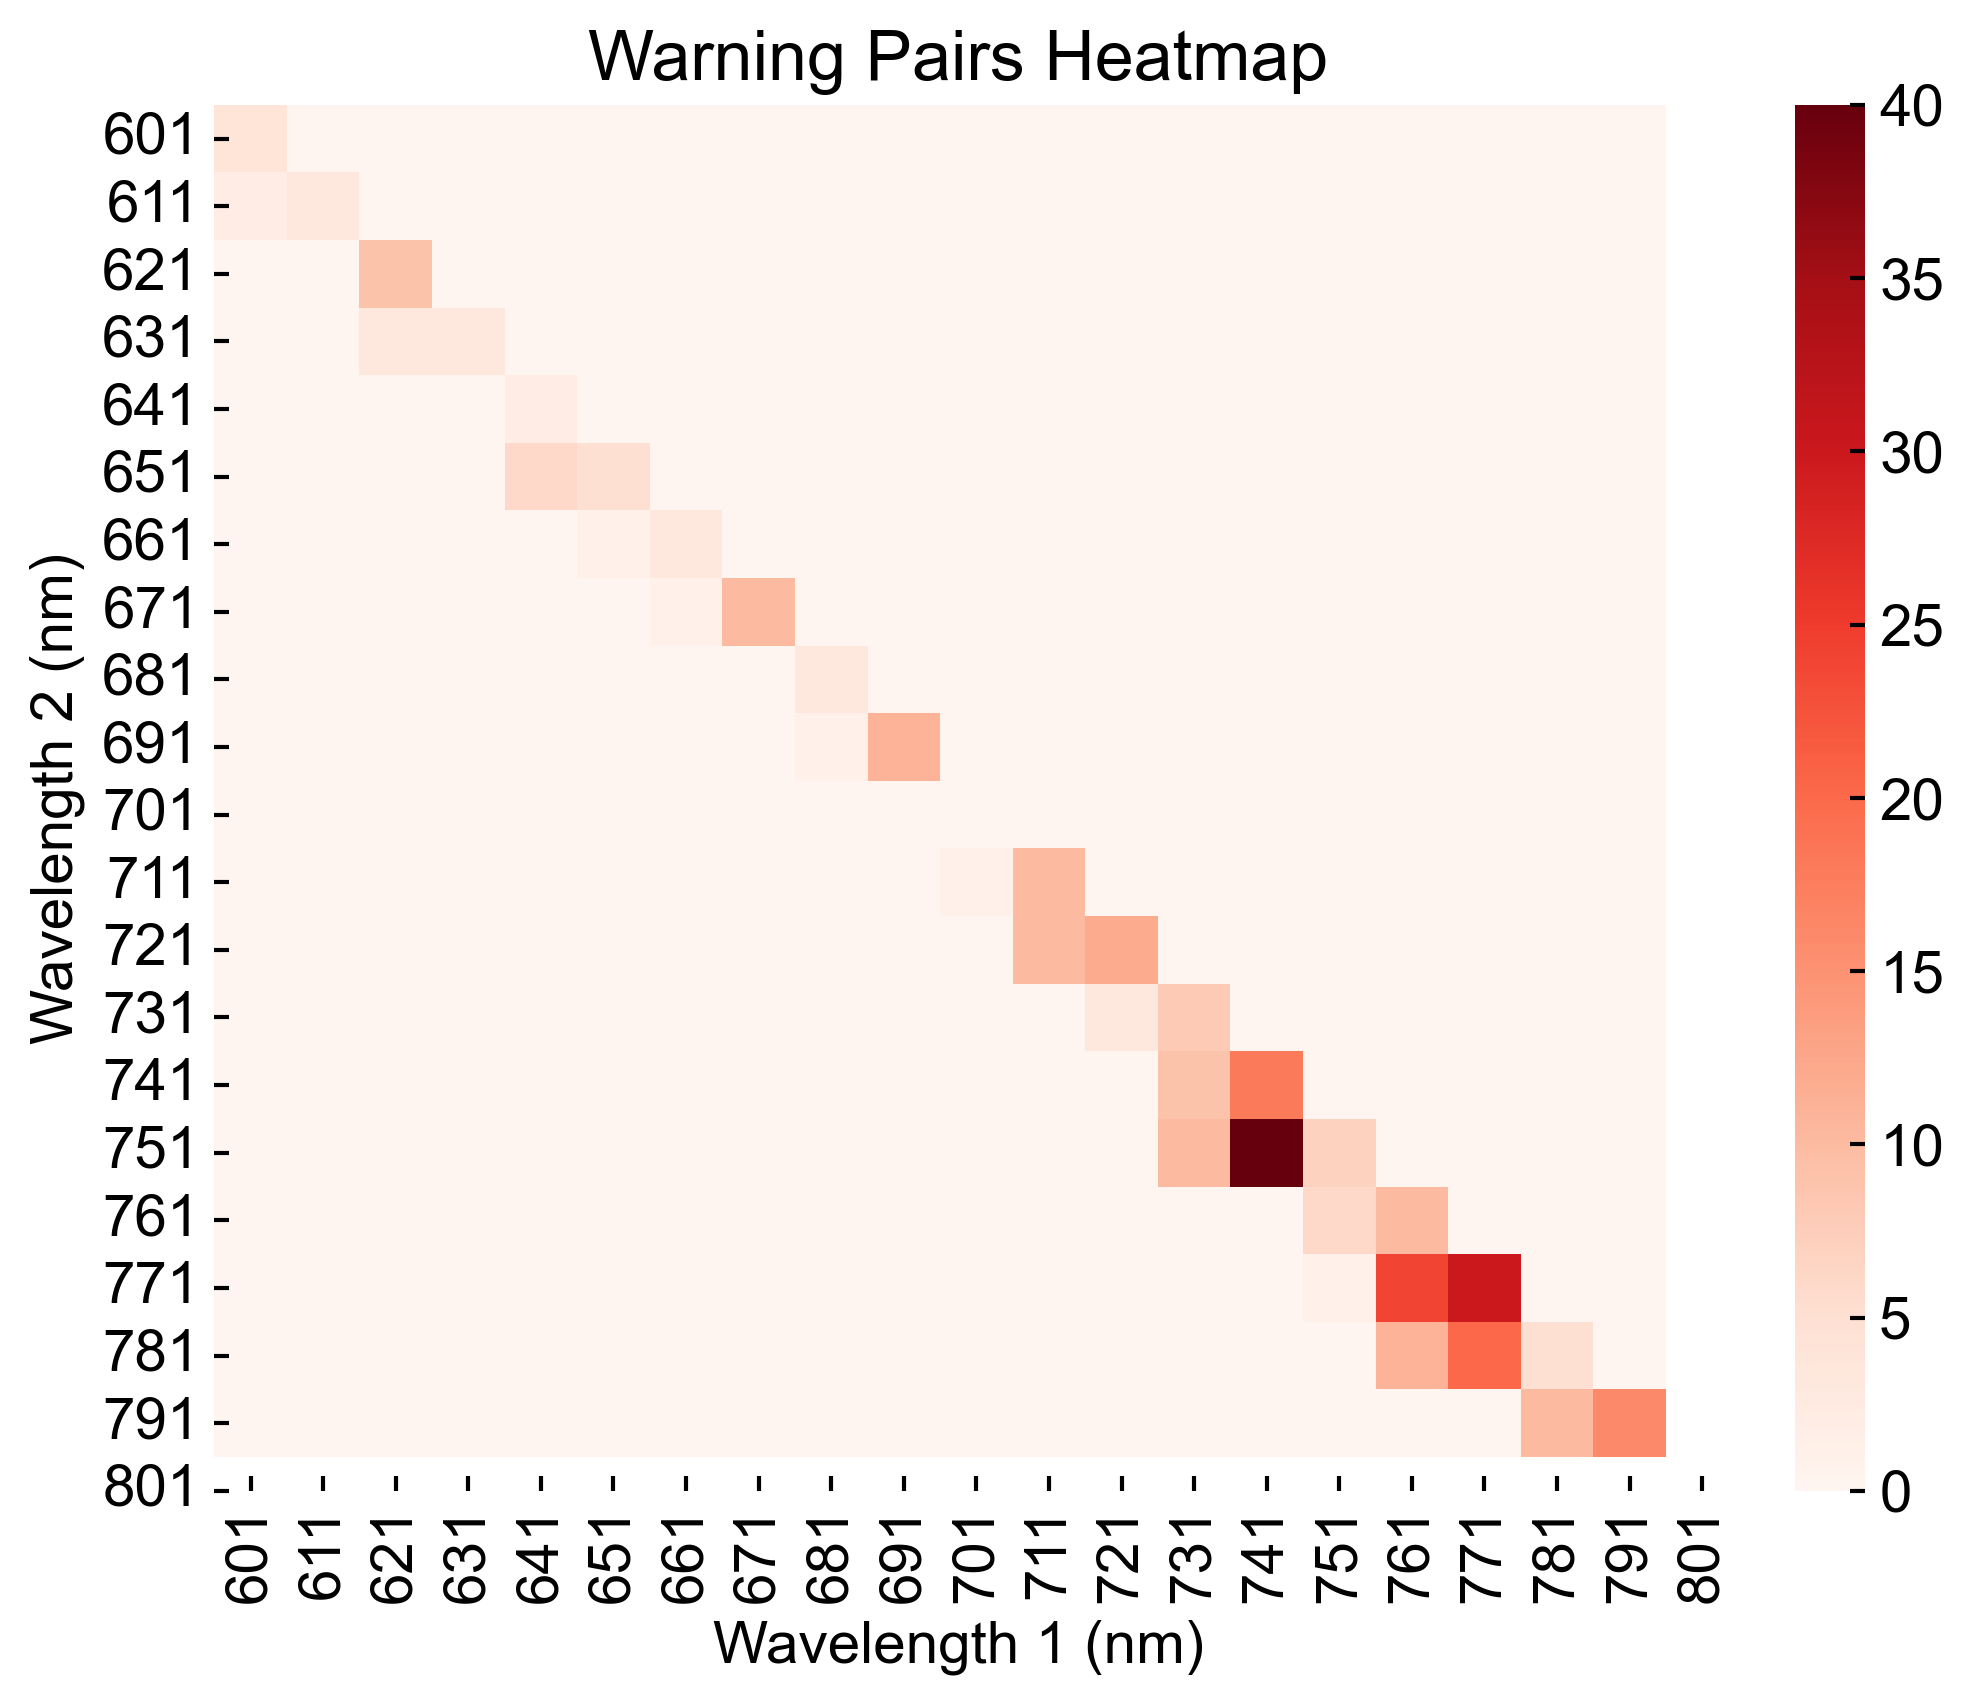

In [178]:
plot_warning_pairs(warning_pairs)
plot_warning_heatmap(warning_pairs)
plt.show()
plt.close()

(array([1.87677460e-06, 3.44075342e-06, 1.87677460e-06, 4.06634496e-06,
        5.31752802e-06, 4.69193649e-06, 5.94311955e-06, 5.31752802e-06,
        6.88150685e-06, 8.75828144e-06, 1.15734433e-05, 1.12606476e-05,
        1.53269925e-05, 1.90805417e-05, 2.22084994e-05, 2.25212951e-05,
        2.59620486e-05, 2.97155978e-05, 3.06539851e-05, 4.09762453e-05,
        4.72321606e-05, 6.31847447e-05, 9.72794832e-05, 1.57336270e-04,
        2.66501992e-04, 5.33003985e-04, 8.89591158e-04, 9.78112360e-04,
        7.72918337e-04, 4.66065691e-04, 2.90587266e-04, 1.75791220e-04,
        1.23554328e-04, 8.28908779e-05, 6.53743151e-05, 5.59904421e-05,
        3.97250623e-05, 3.47203300e-05, 3.06539851e-05, 2.75260274e-05,
        2.69004359e-05, 2.31468867e-05, 1.97061332e-05, 1.53269925e-05,
        1.06350560e-05, 1.21990349e-05, 1.06350560e-05, 1.09478518e-05,
        8.75828144e-06, 8.75828144e-06]),
 array([1100.92353492, 1278.7802371 , 1456.63693927, 1634.49364144,
        1812.35034361, 199

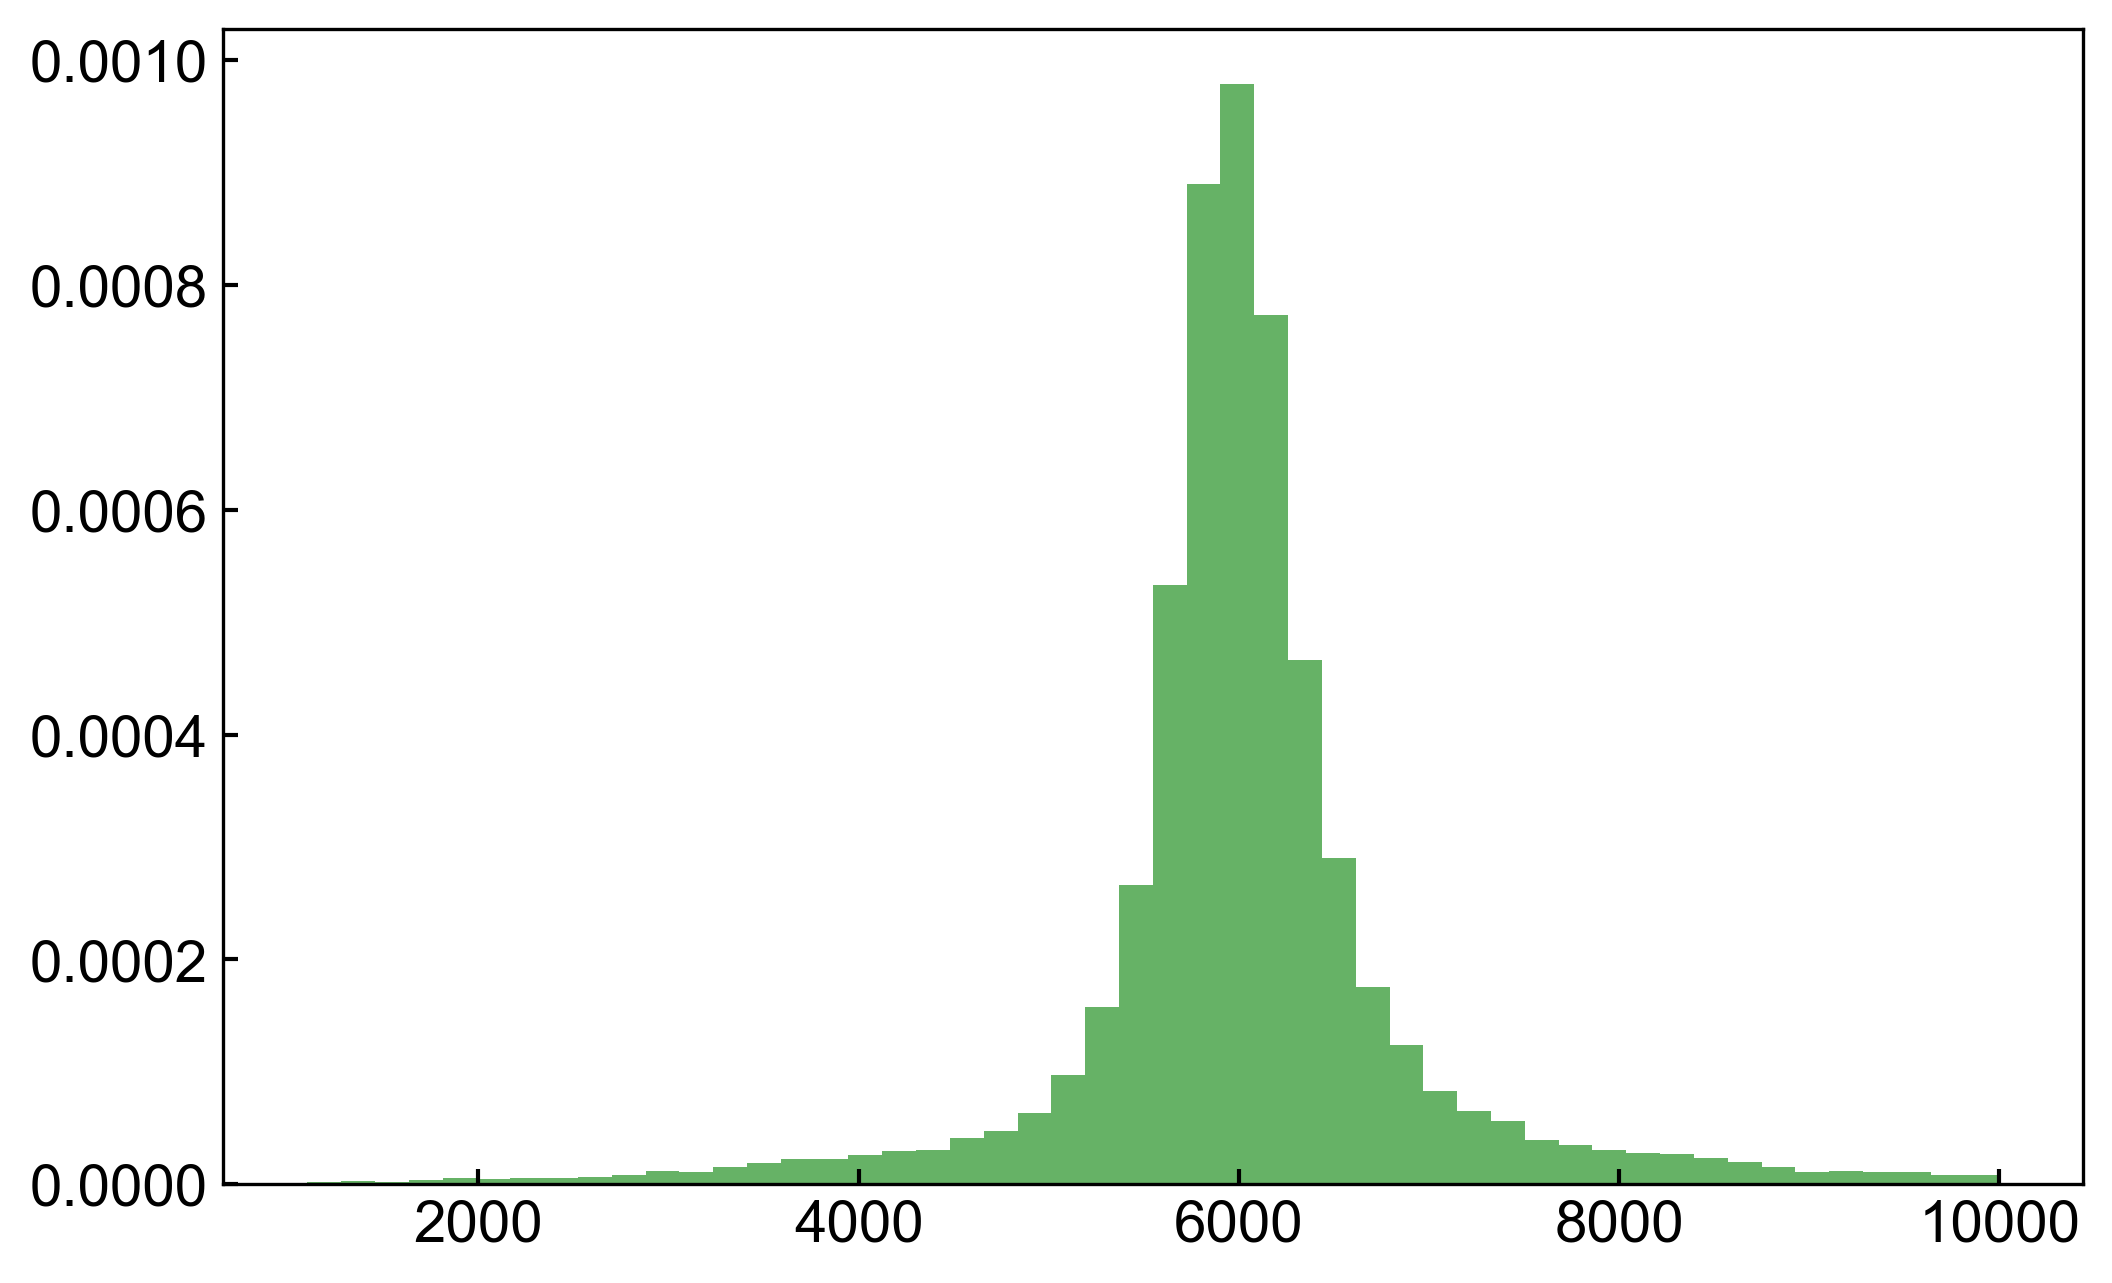

In [170]:

# ヒストグラムを作成
plt.figure(figsize=(8, 5))
plt.hist(temperatures, bins=50, density=True, alpha=0.6, color='g', label='Temperature Histogram')


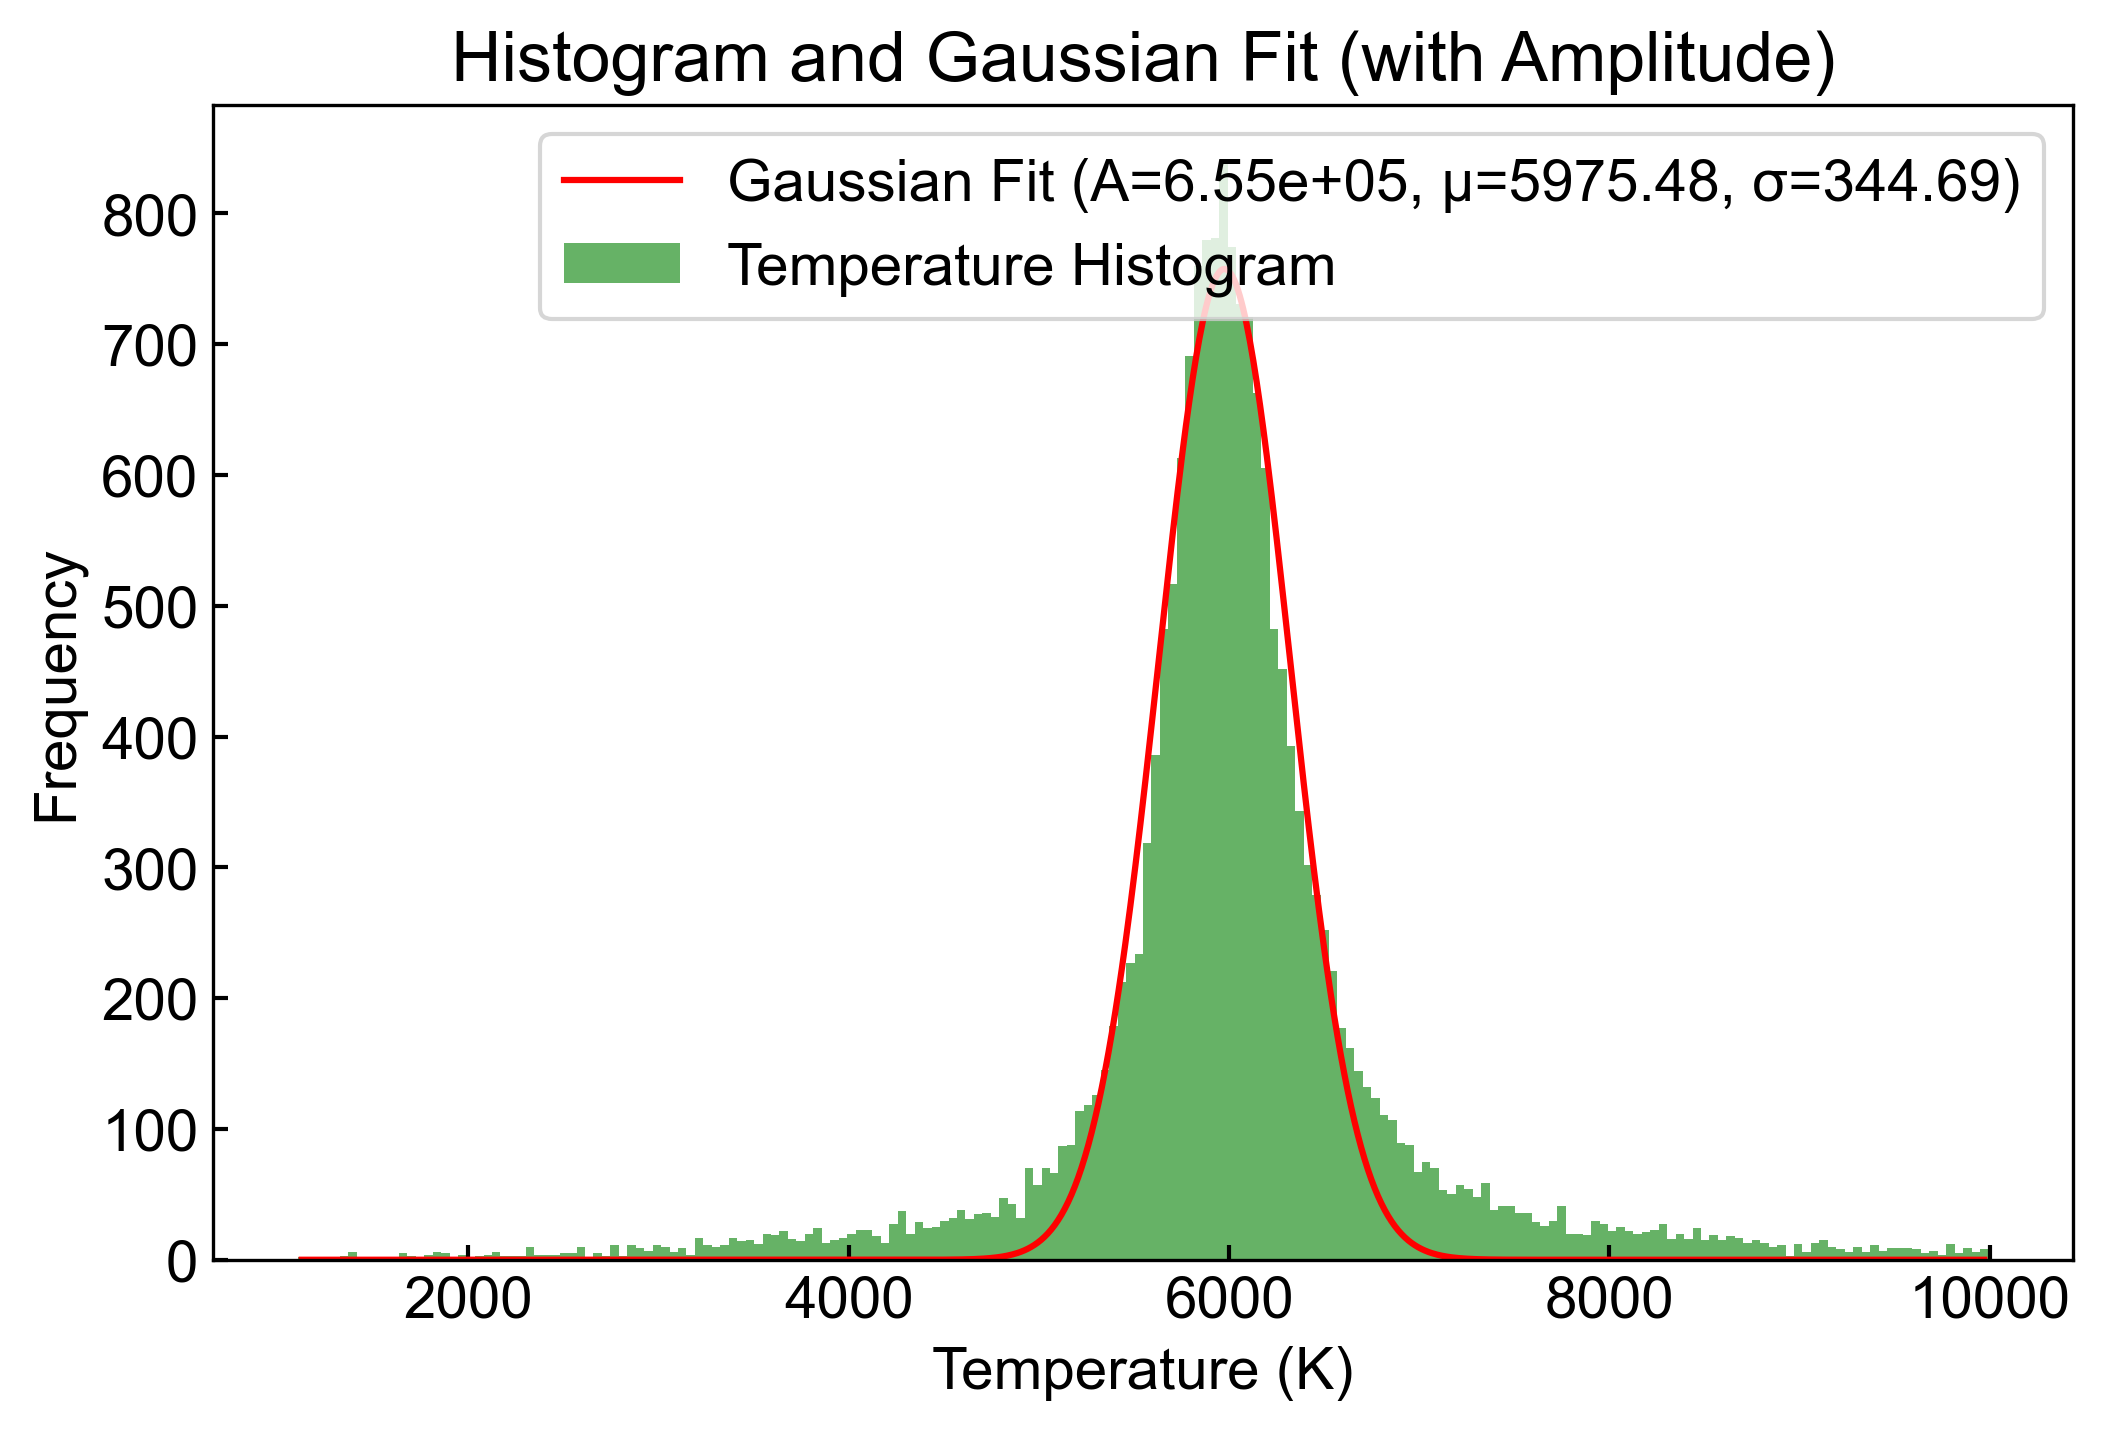

In [187]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit

# ガウシアン関数の定義（振幅 A、平均 mu、標準偏差 sigma を含む）
def gaussian(x, A, mu, sigma):
    """
    ガウシアン（正規分布）関数
    Parameters:
    ----------
    x : array-like
        独立変数（温度）
    A : float
        スケール係数（振幅）
    mu : float
        ガウシアンの平均
    sigma : float
        ガウシアンの標準偏差
    
    Returns:
    -------
    y : array-like
        ガウシアン関数の値
    """
    return A * norm.pdf(x, mu, sigma)

# ヒストグラムを作成（温度データを使用）
hist_values, bin_edges = np.histogram(temperatures, bins=200)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# 初期値を仮定してフィッティングを実行
popt, pcov = curve_fit(gaussian, bin_centers, hist_values, p0=[max(hist_values), np.mean(temperatures), np.std(temperatures)])

# フィット結果のパラメータ
A_fit, mu_fit, sigma_fit = popt

# フィットしたガウシアンを計算
x = np.linspace(min(bin_centers), max(bin_centers), 1000)
y_fit = gaussian(x, A_fit, mu_fit, sigma_fit)

# ヒストグラムとガウシアンフィットをプロット
plt.figure(figsize=(8, 5))
plt.bar(bin_centers, hist_values, width=(bin_edges[1] - bin_edges[0]), alpha=0.6, color='g', label='Temperature Histogram')
plt.plot(x, y_fit, 'r-', label=f'Gaussian Fit (A={A_fit:.2e}, μ={mu_fit:.2f}, σ={sigma_fit:.2f})')

# ラベル・タイトル
plt.xlabel('Temperature (K)')
plt.ylabel('Frequency')
plt.title('Histogram and Gaussian Fit (with Amplitude)')
plt.legend()
plt.show()


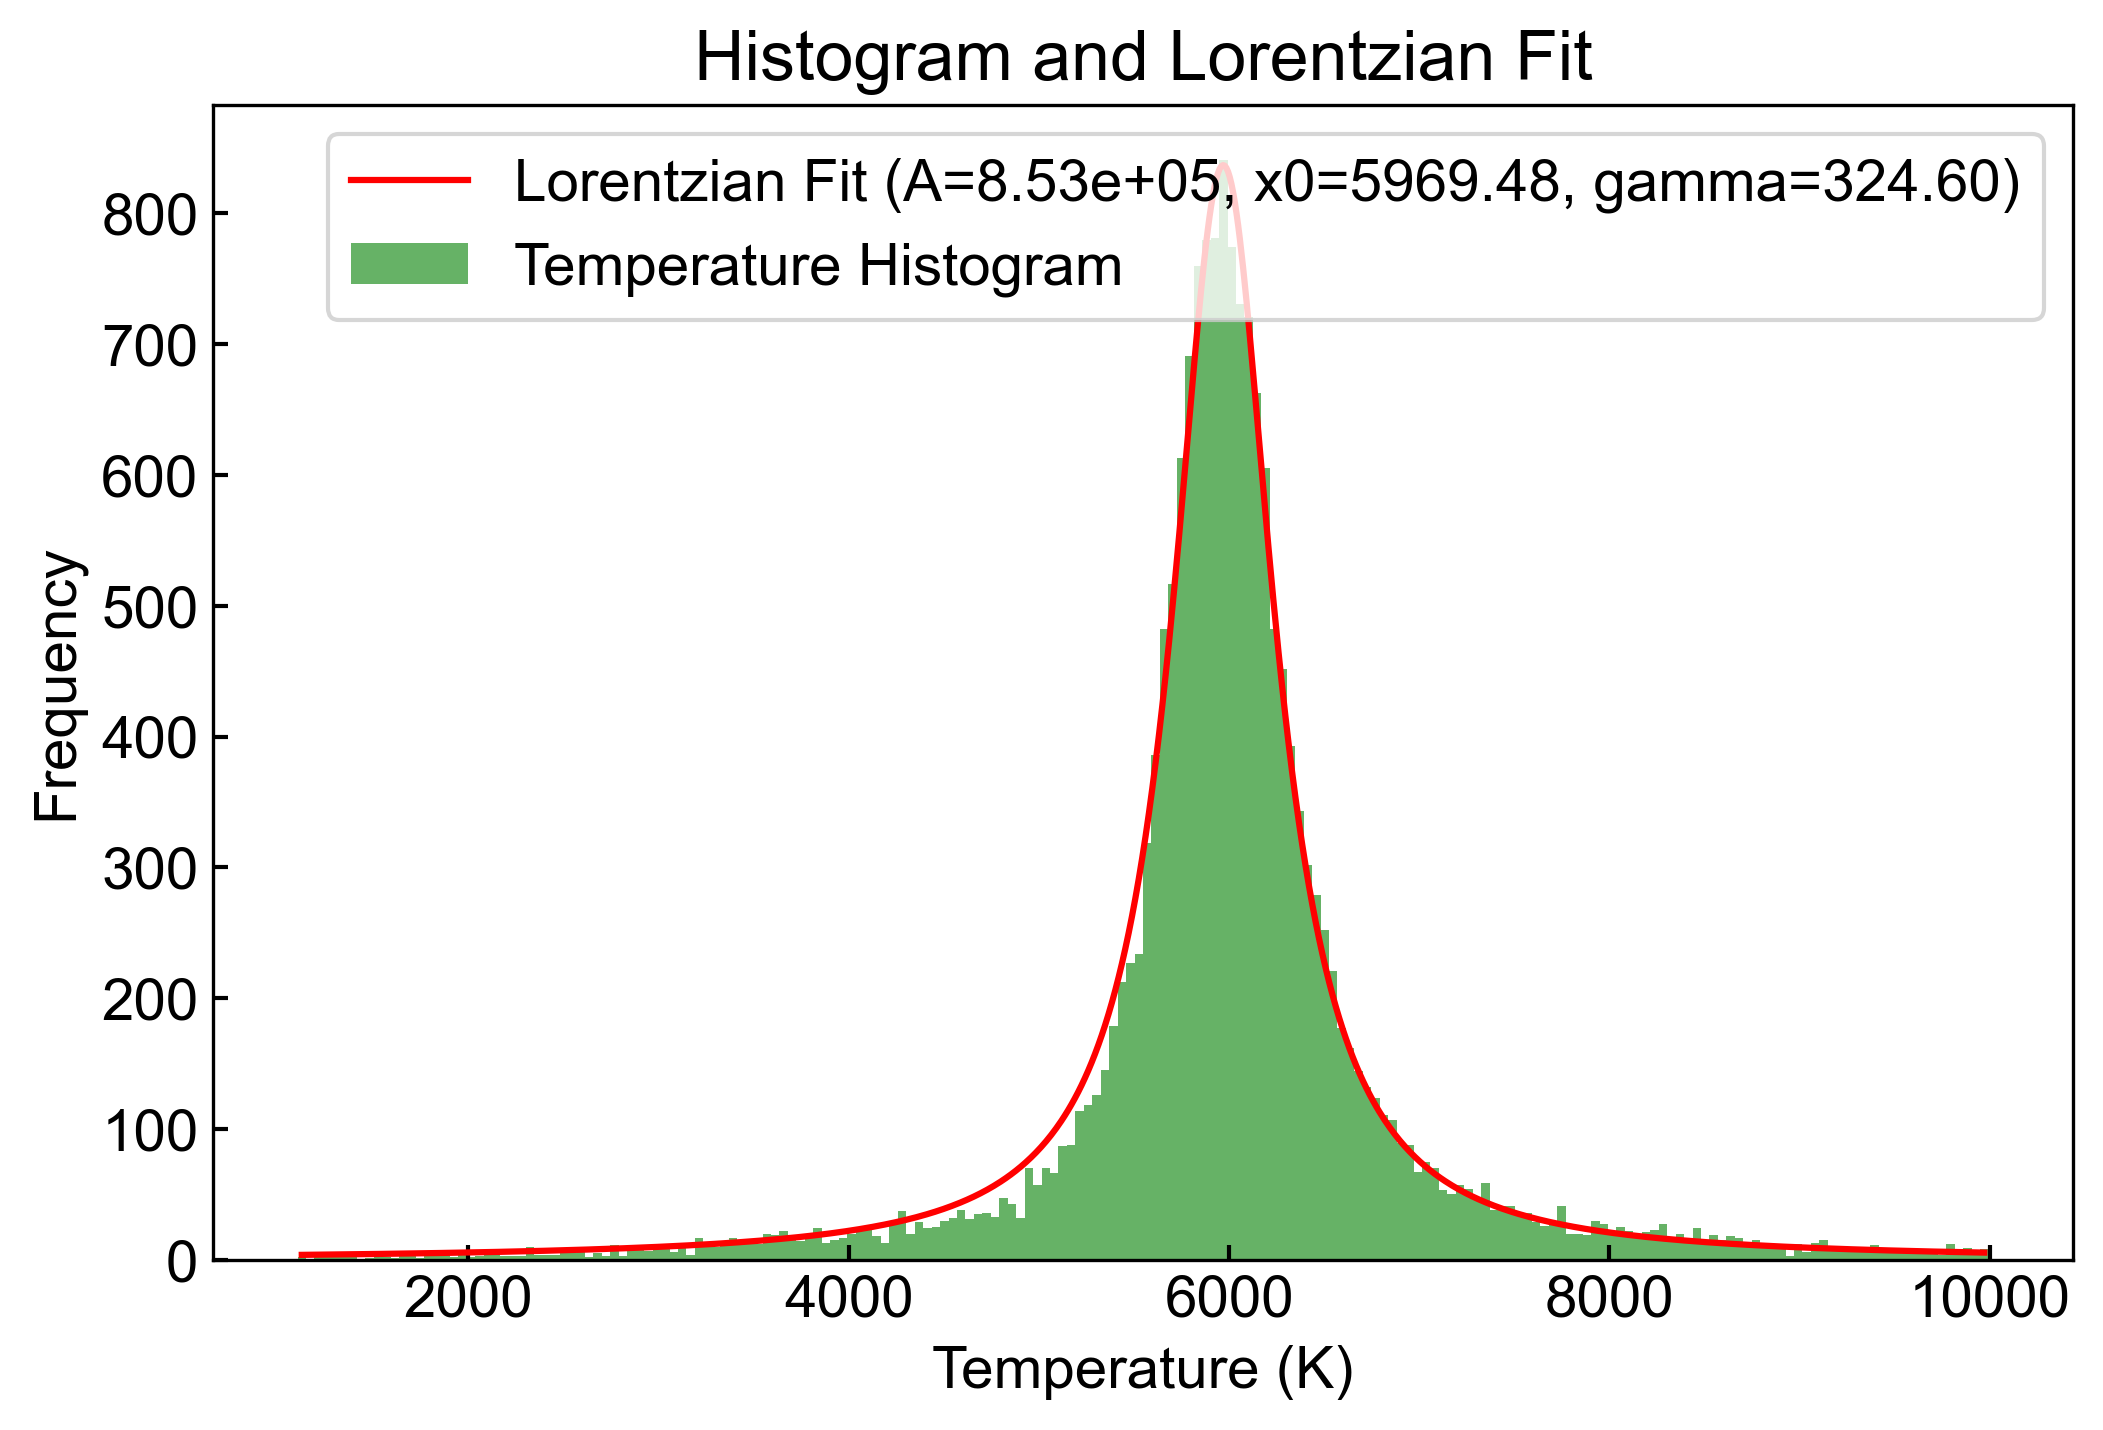

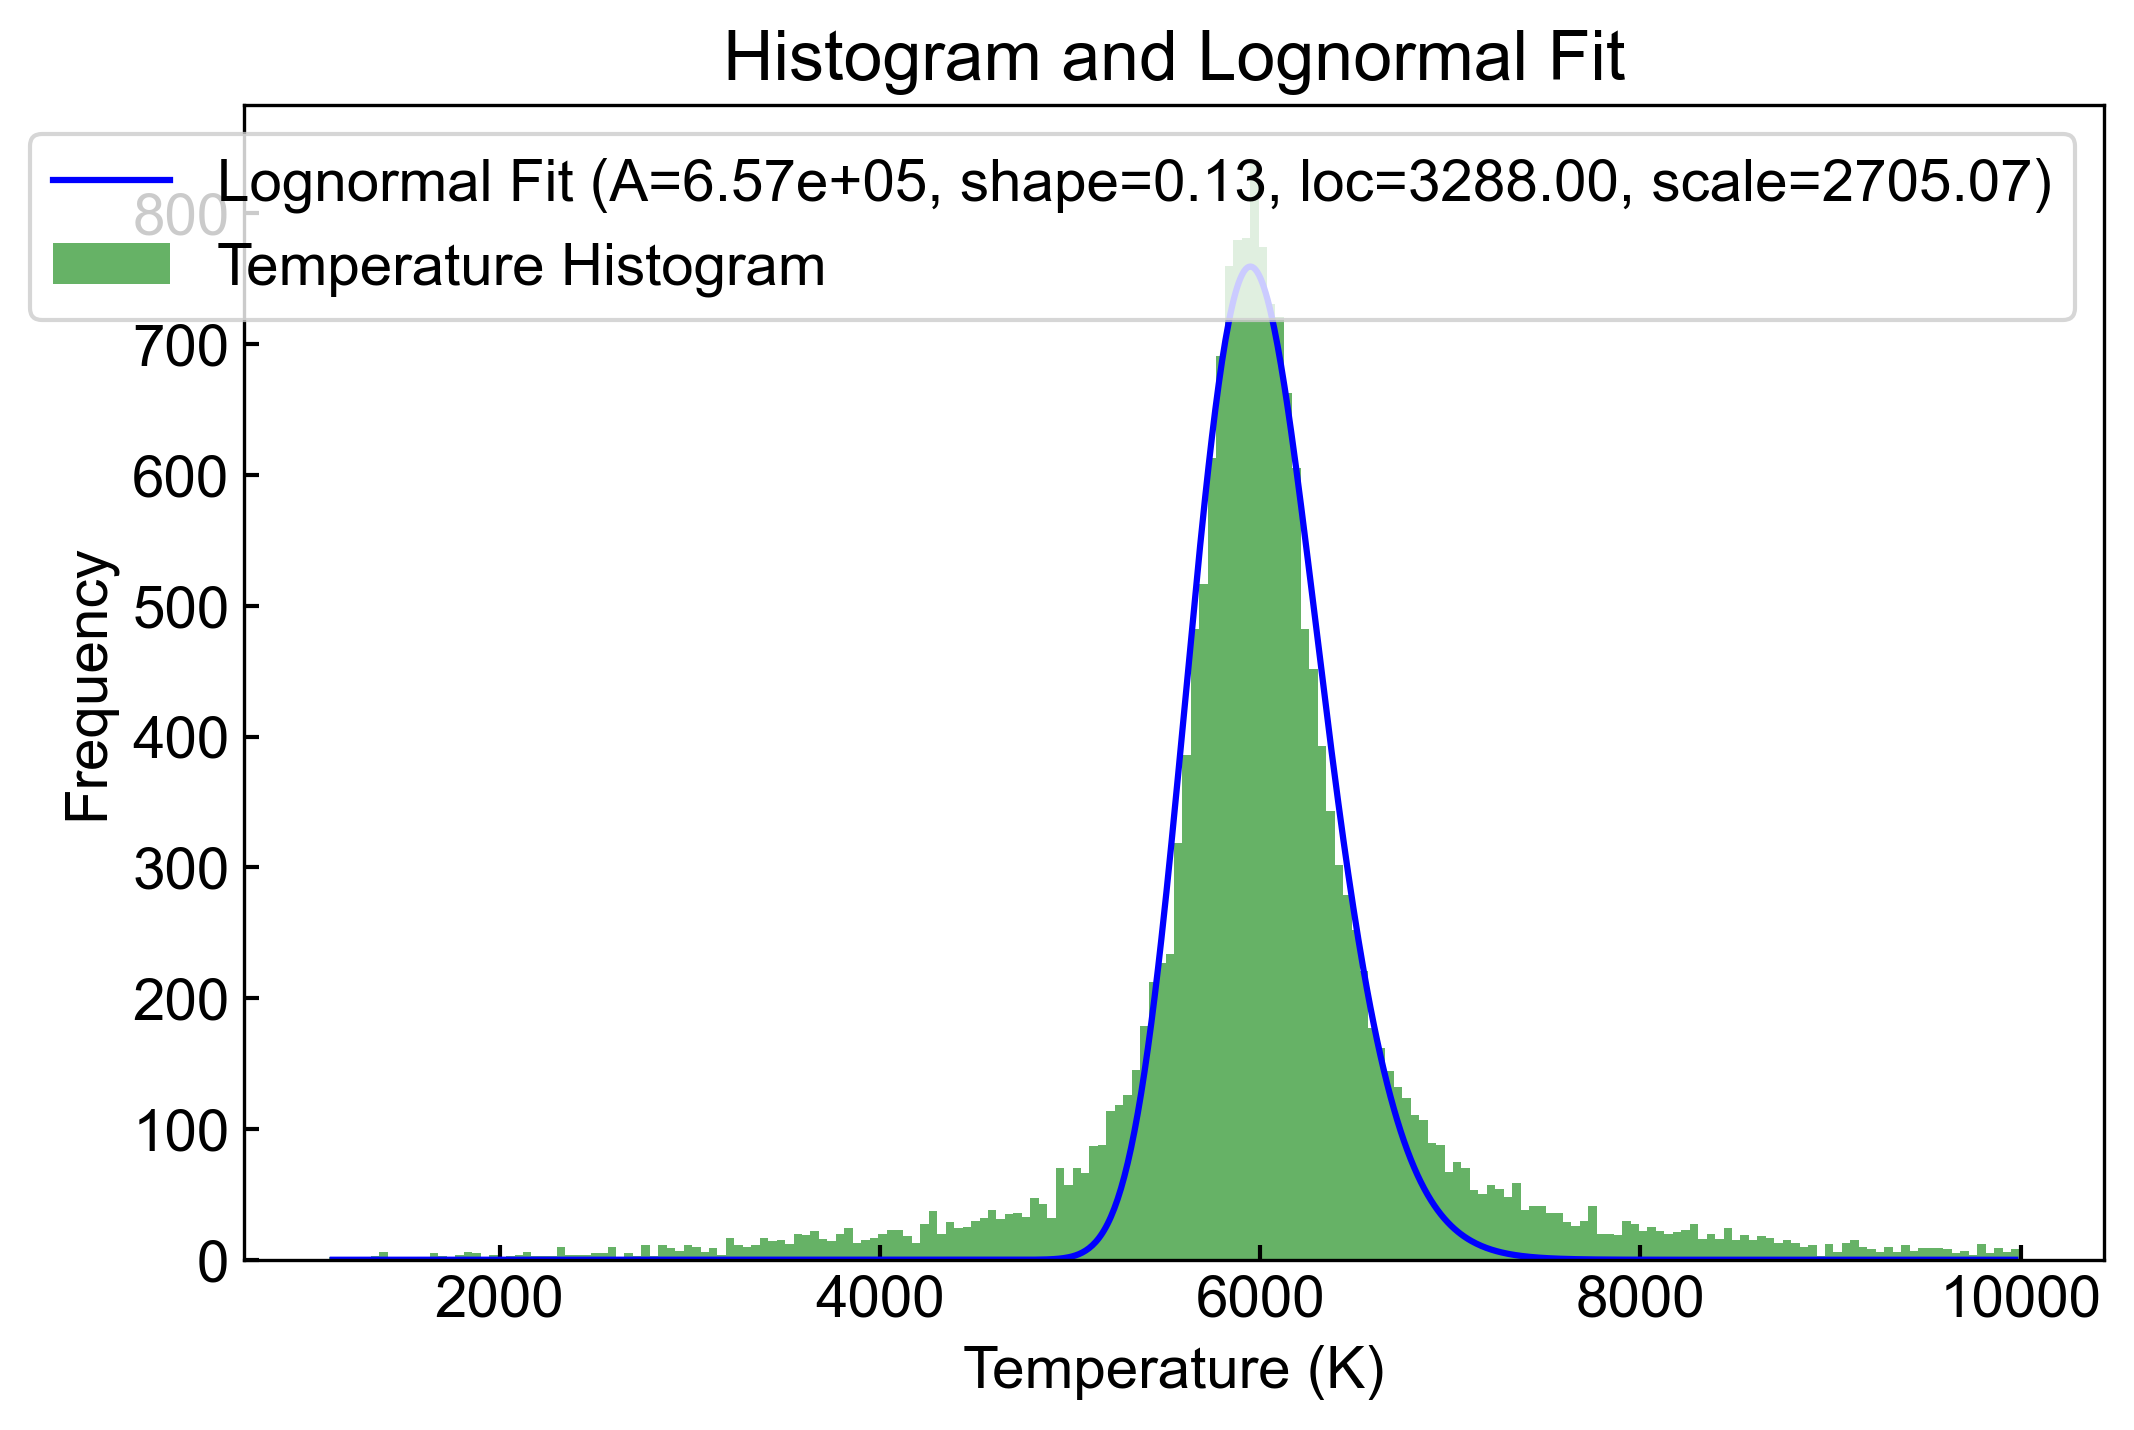

In [189]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cauchy, lognorm
from scipy.optimize import curve_fit

# --- 1. ローレンツ分布（Cauchy分布）のフィッティング --- #
def lorentzian(x, A, x0, gamma):
    """
    ローレンツ分布（Cauchy分布）のPDF
    A : 振幅、x0 : 中心、gamma : 幅
    """
    return A * cauchy.pdf(x, loc=x0, scale=gamma)

# ヒストグラムを作成
hist_values, bin_edges = np.histogram(temperatures, bins=200)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# ローレンツ分布のフィッティング
popt_lorentz, pcov_lorentz = curve_fit(lorentzian, bin_centers, hist_values, p0=[max(hist_values), np.mean(temperatures), 100])

# フィット結果のパラメータ
A_lorentz, x0_lorentz, gamma_lorentz = popt_lorentz

# フィットしたローレンツ分布を計算
x = np.linspace(min(bin_centers), max(bin_centers), 1000)
y_lorentz = lorentzian(x, A_lorentz, x0_lorentz, gamma_lorentz)

# ヒストグラムとローレンツフィットをプロット
plt.figure(figsize=(8, 5))
plt.bar(bin_centers, hist_values, width=(bin_edges[1] - bin_edges[0]), alpha=0.6, color='g', label='Temperature Histogram')
plt.plot(x, y_lorentz, 'r-', label=f'Lorentzian Fit (A={A_lorentz:.2e}, x0={x0_lorentz:.2f}, gamma={gamma_lorentz:.2f})')
plt.xlabel('Temperature (K)')
plt.ylabel('Frequency')
plt.title('Histogram and Lorentzian Fit')
plt.legend()
plt.show()

# --- 2. 対数正規分布（Lognormal分布）のフィッティング --- #
def lognormal(x, A, shape, loc, scale):
    """
    対数正規分布のPDF
    A : 振幅、shape : 形状、loc : 位置、scale : スケール
    """
    return A * lognorm.pdf(x, shape, loc=loc, scale=scale)

# 対数正規分布のフィッティング（maxfev を増加）
popt_lognorm, pcov_lognorm = curve_fit(lognormal, bin_centers, hist_values, p0=[max(hist_values), 0.5, 0, np.mean(temperatures)], maxfev=20000)

# フィット結果のパラメータ
A_lognorm, shape_lognorm, loc_lognorm, scale_lognorm = popt_lognorm

# フィットした対数正規分布を計算
y_lognorm = lognormal(x, A_lognorm, shape_lognorm, loc_lognorm, scale_lognorm)

# ヒストグラムと対数正規分布フィットをプロット
plt.figure(figsize=(8, 5))
plt.bar(bin_centers, hist_values, width=(bin_edges[1] - bin_edges[0]), alpha=0.6, color='g', label='Temperature Histogram')
plt.plot(x, y_lognorm, 'b-', label=f'Lognormal Fit (A={A_lognorm:.2e}, shape={shape_lognorm:.2f}, loc={loc_lognorm:.2f}, scale={scale_lognorm:.2f})')
plt.xlabel('Temperature (K)')
plt.ylabel('Frequency')
plt.title('Histogram and Lognormal Fit')
plt.legend()
plt.show()


Gaussian: A1=5.83e+05, mu1=6123.85, sigma1=336.97
Lorentzian: A2=2.68e+06, mu2=5932.22, gamma2=321.72


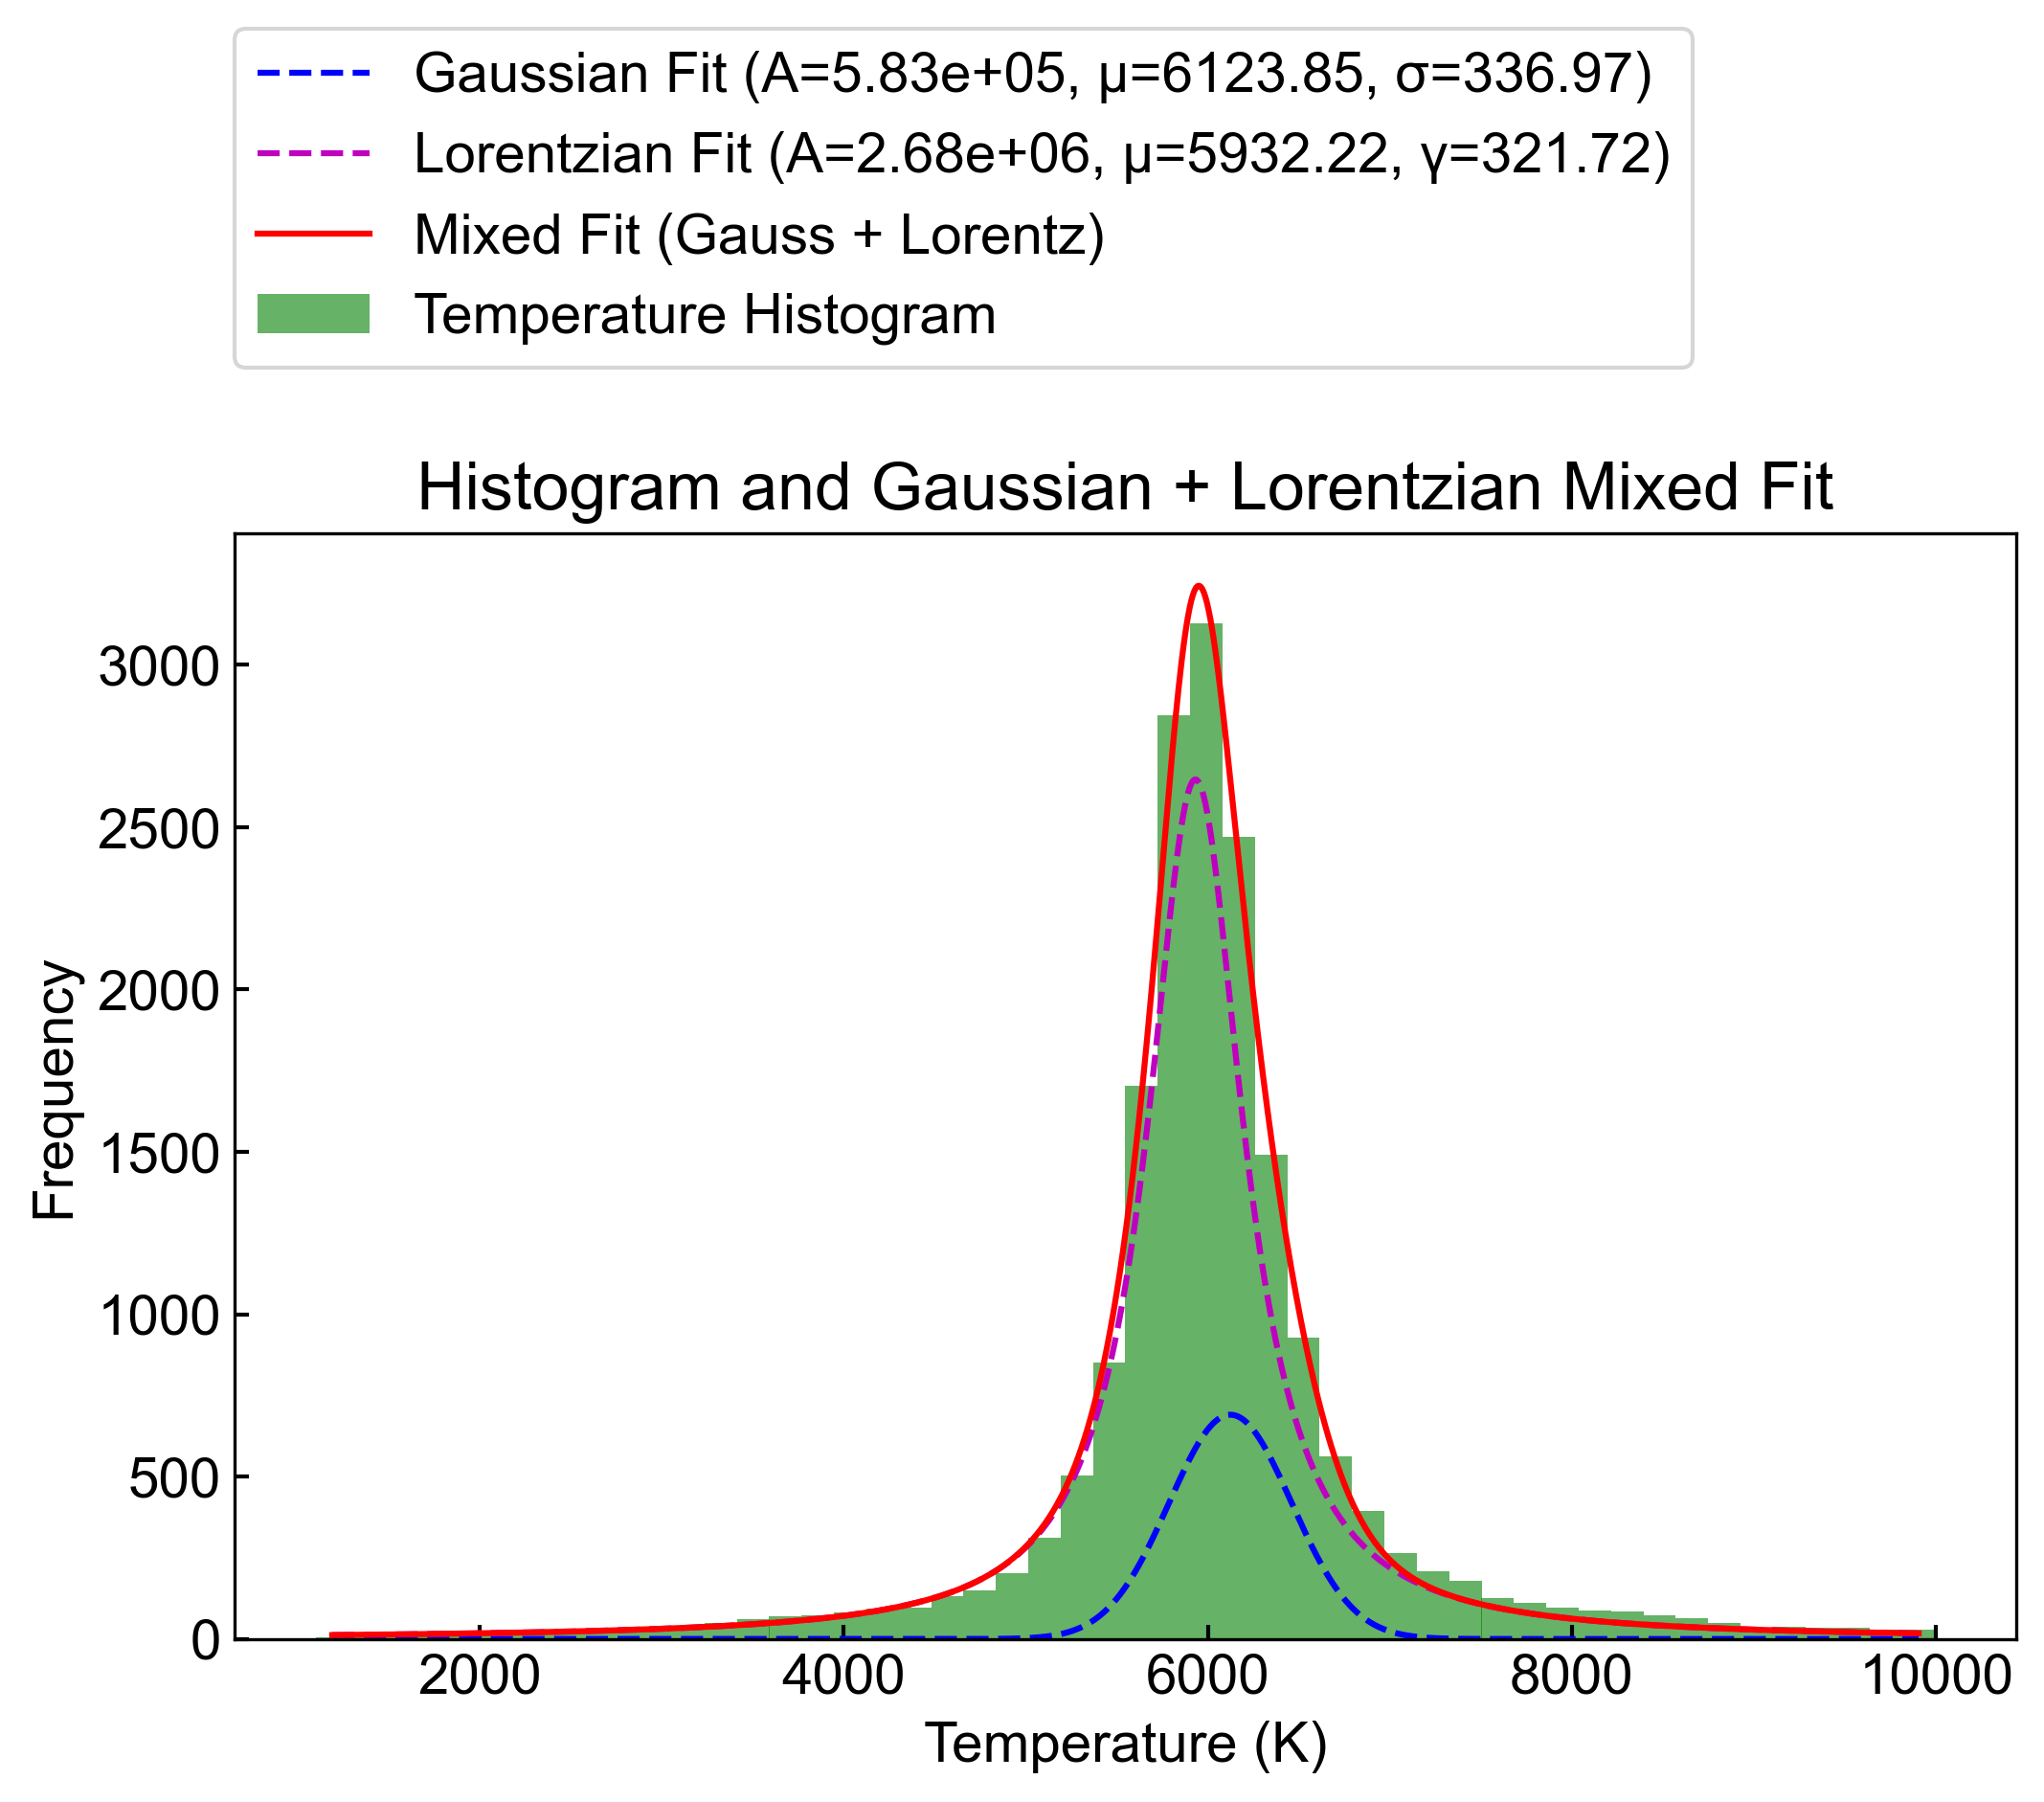

In [203]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm, cauchy

# ヒストグラムを作成（温度データを使用）
hist_values, bin_edges = np.histogram(temperatures, bins=50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# ガウシアンとローレンチアンの混合モデルを定義
def mixed_model(x, A1, mu1, sigma1, A2, mu2, gamma2):
    gauss = A1 * norm.pdf(x, mu1, sigma1)
    lorentz = A2 * cauchy.pdf(x, mu2, gamma2)
    return gauss + lorentz

# 初期値を設定してフィッティングを実行
p0 = [max(hist_values), np.mean(temperatures), np.std(temperatures), max(hist_values)/2, np.mean(temperatures)+100, 200]  # 初期値

# 曲線フィッティング
popt, pcov = curve_fit(mixed_model, bin_centers, hist_values, p0=p0)

# フィット結果のパラメータ
A1_fit, mu1_fit, sigma1_fit, A2_fit, mu2_fit, gamma2_fit = popt

# フィットしたモデルを計算
x_fit = np.linspace(min(bin_centers), max(bin_centers), 1000)
y_fit = mixed_model(x_fit, *popt)

# ガウシアン部分とローレンチアン部分を計算
gauss_fit = A1_fit * norm.pdf(x_fit, mu1_fit, sigma1_fit)
lorentz_fit = A2_fit * cauchy.pdf(x_fit, mu2_fit, gamma2_fit)

# フィット結果を表示
print(f"Gaussian: A1={A1_fit:.2e}, mu1={mu1_fit:.2f}, sigma1={sigma1_fit:.2f}")
print(f"Lorentzian: A2={A2_fit:.2e}, mu2={mu2_fit:.2f}, gamma2={gamma2_fit:.2f}")

# ヒストグラムとガウシアン、ローレンチアン、混合フィットをプロット
plt.figure(figsize=(8, 5))
plt.bar(bin_centers, hist_values, width=(bin_edges[1] - bin_edges[0]), alpha=0.6, color='g', label='Temperature Histogram')
plt.plot(x_fit, gauss_fit, 'b--', label=f'Gaussian Fit (A={A1_fit:.2e}, μ={mu1_fit:.2f}, σ={sigma1_fit:.2f})')
plt.plot(x_fit, lorentz_fit, 'm--', label=f'Lorentzian Fit (A={A2_fit:.2e}, μ={mu2_fit:.2f}, γ={gamma2_fit:.2f})')
plt.plot(x_fit, y_fit, 'r-', label=f'Mixed Fit (Gauss + Lorentz)')

# ラベル・タイトル
plt.xlabel('Temperature (K)')
plt.ylabel('Frequency')
plt.title('Histogram and Gaussian + Lorentzian Mixed Fit')
plt.legend(loc=(0, 1.15))
plt.show()



In [205]:
# ガウシアンとローレンチアンの平均値と広がりの重み付き平均を計算
mu_weighted = (A1_fit * mu1_fit + A2_fit * mu2_fit) / (A1_fit + A2_fit)
sigma_weighted = (A1_fit * sigma1_fit + A2_fit * gamma2_fit) / (A1_fit + A2_fit)

mu_weighted, sigma_weighted, sigma_weighted/mu_weighted

(np.float64(5966.52320441608),
 np.float64(324.4468197960481),
 np.float64(0.054377869435907174))

# データセット1に対する一括処理の実装

# データセット2でも確認